# Exploratory Data Analysis (EDA) - MedOn vs MedOff Comparison

## Purpose

This notebook implements **Phase 1: Exploratory Data Analysis** from the analysis pipeline outlined in `Analysis_Pipeline.md`.

### Goals

1. **Understand data structure**: Load all patient features and examine the organization
2. **Identify patterns**: Explore distributions and relationships between features
3. **Data quality checks**: Identify outliers, missing data, and potential issues
4. **Prepare for statistical testing**: Understand feature characteristics before hypothesis testing

### Dataset Overview

- **14 patients** with extracted topological features from LFP recordings
- **9 paired patients** with both medOn and medOff states (primary analysis group)
- **28 scalar features** per observation (7 features × 4 homology dimensions H0-H3)
- **2 hemispheres** (dominant/nondominant) × **2 conditions** (hold/resting)
- **Array-based features** available: persistence landscapes, Betti curves, heat kernels

### Analysis Steps

1. Load all patient data using `data_loader.py`
2. Compute descriptive statistics (mean, median, std, range)
3. Visualize feature distributions (histograms, Q-Q plots)
4. Check for outliers and data quality issues
5. Correlation analysis within and between medication states
6. PCA visualization to explore high-dimensional structure
7. Preliminary comparison of medOn vs medOff patterns

### Expected Outcomes

- Clear understanding of feature distributions and ranges
- Identification of potentially discriminative features
- Detection of any data quality issues requiring attention
- Foundation for statistical testing in subsequent notebooks


In [36]:
# Standard data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Machine learning libraries (for PCA and preprocessing)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope

# TDA libraries (giotto-tda)
from gtda.diagrams import PersistenceEntropy, PersistenceLandscape, BettiCurve, HeatKernel
from gtda.plotting import plot_diagram, plot_betti_curves
# Local analysis modules
from data_loader import (
    load_all_patients, 
    get_paired_patients_data,
    load_patient_features,
    extract_array_features,
    get_patient_availability
)
from analysis_utils import (
    paired_ttest,
    compute_effect_size,
    create_summary_table,
    summarize_persistence_landscape,
    summarize_betti_curve,
    summarize_heat_kernel
)
from visualization_utils import (
    plot_paired_scatter,
    plot_distribution_comparison,
    plot_forest,
    plot_landscape_comparison,
    plot_betti_comparison
)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

✓ All libraries imported successfully
NumPy version: 1.24.4
Pandas version: 2.0.3
Matplotlib version: 3.7.3
Seaborn version: 0.13.2


In [52]:
# Load all patient data with verbose output
print("Loading all patient data...")
print("="*70)

df_all = load_all_patients(verbose=True)

print("\n" + "="*70)
print("FILTERING TO PAIRED PATIENTS")
print("="*70)

# Get only patients with both medOn and medOff (most useful for paired comparisons)
df_paired = get_paired_patients_data(df_all)

print(f"\nPaired patients DataFrame shape: {df_paired.shape}")
print(f"Number of paired patients: {df_paired['patient_id'].nunique()}")
print(f"Patients included: {sorted(df_paired['patient_id'].unique().tolist())}")

# Display basic information
print("\n" + "="*70)
print("DATA STRUCTURE OVERVIEW")
print("="*70)
print(f"\nAll patients data shape: {df_all.shape}")
print(f"Paired patients data shape: {df_paired.shape}")
print(f"\nColumns in dataset: {len(df_all.columns)}")
print(f"  - Identifier columns: 4 (patient_id, med_state, hemisphere, condition)")
print(f"  - Feature columns: {len(df_all.columns) - 4}")

# Show first few rows
print("\n" + "="*70)
print("SAMPLE DATA (First 5 rows)")
print("="*70)
display(df_all.head())

# Show data types
print("\n" + "="*70)
print("DATA TYPES")
print("="*70)
print(df_all.dtypes)

Loading all patient data...

LOADING ALL PATIENTS - OVERVIEW
Total patients: 14
  • Paired (medOn + medOff): 9
  • MedOff only: 3
  • MedOn only: 2

[1/14] Processing 0cGdk9...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[2/14] Processing 2IhVOz...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[3/14] Processing 2IU8mi...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[4/14] Processing AB2PeX...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[5/14] Processing AbzsOg...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[6/14] Processing BYJoWR...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[7/14] Processing dCsWjQ...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[8/14] Processing FYbcap...
  ✓ Loaded: 4 medOn rows, 0 medOff rows

[9/14] Processing gNX5yb...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[10/14] Processing i4oK0F...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[11/14] Processing jyC0j3...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[12/14] Processing PuPVlx...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[13/14] Processing Q

,patient_id,med_state,hemisphere,condition,h0_feature_count,h0_avg_lifespan,h0_max_lifespan,h0_std_lifespan,h0_avg_birth,h0_avg_death,h1_feature_count,h1_avg_lifespan,h1_max_lifespan,h1_std_lifespan,h1_avg_birth,h1_avg_death,h2_feature_count,h2_avg_lifespan,h2_max_lifespan,h2_std_lifespan,h2_avg_birth,h2_avg_death,h3_feature_count,h3_avg_lifespan,h3_max_lifespan,h3_std_lifespan,h3_avg_birth,h3_avg_death,h0_persistence_entropy,h1_persistence_entropy,h2_persistence_entropy,h3_persistence_entropy
0,0cGdk9,medOn,nondominant,hold,249.0,1.641,3.134,0.441,0.0,1.641,149.0,0.213,0.807,0.177,2.157,2.370,48.0,0.077,0.233,0.053,2.624,2.701,5.0,0.043,0.091,0.032,2.900,2.943,7.909,6.732,5.223,1.908
1,0cGdk9,medOn,dominant,hold,249.0,0.923,1.775,0.253,0.0,0.923,187.0,0.115,0.497,0.089,1.162,1.276,77.0,0.047,0.168,0.041,1.431,1.478,12.0,0.016,0.037,0.011,1.567,1.582,7.908,7.140,5.754,3.243
2,0cGdk9,medOn,nondominant,resting,249.0,1.818,3.200,0.394,0.0,1.818,186.0,0.216,0.808,0.159,2.265,2.481,78.0,0.087,0.364,0.078,2.758,2.845,13.0,0.042,0.143,0.037,2.980,3.022,7.925,7.155,5.757,3.234
3,0cGdk9,medOn,dominant,resting,249.0,0.767,2.044,0.318,0.0,0.767,150.0,0.096,0.498,0.082,0.976,1.072,46.0,0.046,0.201,0.040,1.132,1.178,6.0,0.011,0.037,0.012,1.171,1.182,7.847,6.764,5.041,1.782
4,0cGdk9,medOff,nondominant,hold,249.0,1.518,2.785,0.417,0.0,1.518,186.0,0.183,0.575,0.135,1.935,2.118,85.0,0.082,0.361,0.064,2.290,2.372,22.0,0.061,0.198,0.056,2.451,2.512,7.907,7.136,6.001,3.829



DATA TYPES
patient_id                 object
med_state                  object
hemisphere                 object
condition                  object
h0_feature_count          float64
h0_avg_lifespan           float64
h0_max_lifespan           float64
h0_std_lifespan           float64
h0_avg_birth              float64
h0_avg_death              float64
h1_feature_count          float64
h1_avg_lifespan           float64
h1_max_lifespan           float64
h1_std_lifespan           float64
h1_avg_birth              float64
h1_avg_death              float64
h2_feature_count          float64
h2_avg_lifespan           float64
h2_max_lifespan           float64
h2_std_lifespan           float64
h2_avg_birth              float64
h2_avg_death              float64
h3_feature_count          float64
h3_avg_lifespan           float64
h3_max_lifespan           float64
h3_std_lifespan           float64
h3_avg_birth              float64
h3_avg_death              float64
h0_persistence_entropy    float64
h1

In [39]:
df.isnull().sum()

patient_id                0
med_state                 0
hemisphere                0
condition                 0
h0_feature_count          0
h0_avg_lifespan           0
h0_max_lifespan           0
h0_std_lifespan           0
h0_avg_birth              0
h0_avg_death              0
h1_feature_count          0
h1_avg_lifespan           0
h1_max_lifespan           0
h1_std_lifespan           0
h1_avg_birth              0
h1_avg_death              0
h2_feature_count          0
h2_avg_lifespan           0
h2_max_lifespan           0
h2_std_lifespan           0
h2_avg_birth              0
h2_avg_death              0
h3_feature_count          0
h3_avg_lifespan           0
h3_max_lifespan           0
h3_std_lifespan           0
h3_avg_birth              0
h3_avg_death              0
h0_persistence_entropy    0
h1_persistence_entropy    0
h2_persistence_entropy    0
h3_persistence_entropy    0
dtype: int64

In [53]:
df.describe()

,h0_feature_count,h0_avg_lifespan,h0_max_lifespan,h0_std_lifespan,h0_avg_death,h1_feature_count,h1_avg_lifespan,h1_max_lifespan,h1_std_lifespan,h1_avg_birth,h1_avg_death,h2_feature_count,h2_avg_lifespan,h2_max_lifespan,h2_std_lifespan,h2_avg_birth,h2_avg_death,h3_feature_count,h3_avg_lifespan,h3_max_lifespan,h3_std_lifespan,h3_avg_birth,h3_avg_death,h0_persistence_entropy,h1_persistence_entropy,h2_persistence_entropy,h3_persistence_entropy
count,92.0,92.000,92.000,92.000,92.000,92.00,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000,92.000
mean,249.0,2.122,4.487,0.644,2.122,166.88,0.289,1.152,0.236,2.793,3.082,63.674,0.132,0.491,0.112,3.443,3.575,14.196,0.075,0.202,0.059,3.831,3.907,7.893,6.909,5.420,3.055
std,0.0,1.202,2.640,0.372,1.202,19.87,0.180,0.759,0.151,1.625,1.801,19.894,0.080,0.305,0.068,2.016,2.094,8.874,0.048,0.124,0.040,2.282,2.324,0.024,0.188,0.500,0.987
min,249.0,0.504,0.953,0.129,0.504,115.00,0.071,0.250,0.057,0.672,0.743,19.000,0.034,0.119,0.030,0.828,0.867,1.000,0.010,0.019,0.000,0.966,0.992,7.779,6.343,3.269,0.000
25%,249.0,1.165,2.430,0.355,1.165,154.50,0.156,0.597,0.126,1.560,1.729,48.750,0.072,0.256,0.059,1.881,1.952,7.000,0.041,0.098,0.030,2.046,2.086,7.885,6.800,5.174,2.407
50%,249.0,1.814,3.781,0.529,1.814,167.00,0.224,0.901,0.182,2.308,2.533,63.000,0.104,0.371,0.086,2.758,2.857,12.500,0.058,0.178,0.047,3.010,3.057,7.897,6.897,5.481,3.171
75%,249.0,2.777,5.744,0.864,2.777,182.25,0.372,1.472,0.302,3.593,3.977,75.250,0.170,0.647,0.148,4.489,4.694,17.250,0.101,0.262,0.075,5.092,5.200,7.907,7.063,5.742,3.667
max,249.0,6.856,12.618,1.910,6.856,225.00,1.061,4.079,0.872,9.757,10.819,130.000,0.472,1.500,0.364,11.936,12.408,50.000,0.240,0.542,0.191,12.918,13.102,7.930,7.409,6.479,5.156


# Distribution Analysis
## Dominant and Non-dominant hemispheres pooled

In [54]:
# Organize feature columns by type
# Get all feature columns (exclude identifiers)
identifier_cols = ['patient_id', 'med_state', 'hemisphere', 'condition']
feature_cols = [col for col in df_all.columns if col not in identifier_cols]

# Group features by homology dimension and type
h0_features = [col for col in feature_cols if col.startswith('h0_')]
h1_features = [col for col in feature_cols if col.startswith('h1_')]
h2_features = [col for col in feature_cols if col.startswith('h2_')]
h3_features = [col for col in feature_cols if col.startswith('h3_')]

# Key features for visualization (one per dimension)
key_features = {
    'H0': ['h0_feature_count', 'h0_avg_lifespan', 'h0_persistence_entropy'],
    'H1': ['h1_feature_count', 'h1_avg_lifespan', 'h1_persistence_entropy'],
    'H2': ['h2_feature_count', 'h2_avg_lifespan', 'h2_persistence_entropy'],
    'H3': ['h3_feature_count', 'h3_avg_lifespan', 'h3_persistence_entropy']
}

print("Feature Organization:")
print("="*70)
print(f"Total features: {len(feature_cols)}")
print(f"  H0 features: {len(h0_features)}")
print(f"  H1 features: {len(h1_features)}")
print(f"  H2 features: {len(h2_features)}")
print(f"  H3 features: {len(h3_features)}")
print(f"\nKey features for visualization:")
for dim, feats in key_features.items():
    print(f"  {dim}: {feats}")

Feature Organization:
Total features: 28
  H0 features: 7
  H1 features: 7
  H2 features: 7
  H3 features: 7

Key features for visualization:
  H0: ['h0_feature_count', 'h0_avg_lifespan', 'h0_persistence_entropy']
  H1: ['h1_feature_count', 'h1_avg_lifespan', 'h1_persistence_entropy']
  H2: ['h2_feature_count', 'h2_avg_lifespan', 'h2_persistence_entropy']
  H3: ['h3_feature_count', 'h3_avg_lifespan', 'h3_persistence_entropy']


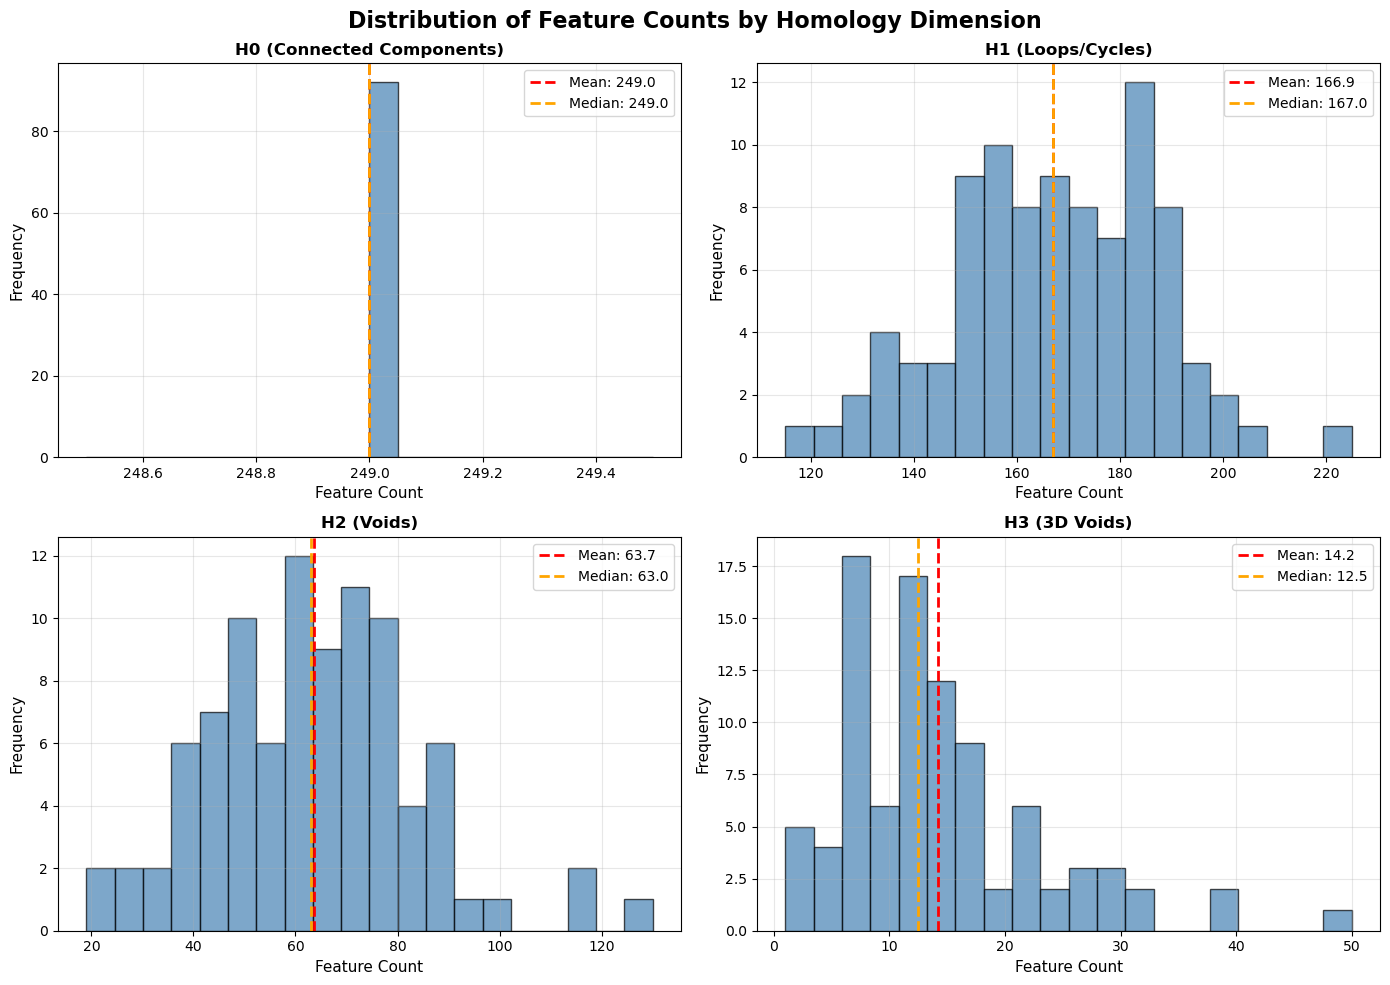


Feature Count Statistics:

H0 (Connected Components):
  Mean: 249.00
  Median: 249.00
  Std: 0.00
  Range: [249, 249]

H1 (Loops/Cycles):
  Mean: 166.88
  Median: 167.00
  Std: 19.87
  Range: [115, 225]

H2 (Voids):
  Mean: 63.67
  Median: 63.00
  Std: 19.89
  Range: [19, 130]

H3 (3D Voids):
  Mean: 14.20
  Median: 12.50
  Std: 8.87
  Range: [1, 50]


In [55]:
# Histogram analysis for feature counts across all homology dimensions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Feature Counts by Homology Dimension', fontsize=16, fontweight='bold')

count_features = ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count']
dims = ['H0 (Connected Components)', 'H1 (Loops/Cycles)', 'H2 (Voids)', 'H3 (3D Voids)']

for idx, (feature, dim_name) in enumerate(zip(count_features, dims)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Plot histogram
    ax.hist(df_all[feature], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(df_all[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_all[feature].mean():.1f}')
    ax.axvline(df_all[feature].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_all[feature].median():.1f}')
    
    ax.set_xlabel('Feature Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{dim_name}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nFeature Count Statistics:")
print("="*70)
for feature, dim_name in zip(count_features, dims):
    print(f"\n{dim_name}:")
    print(f"  Mean: {df_all[feature].mean():.2f}")
    print(f"  Median: {df_all[feature].median():.2f}")
    print(f"  Std: {df_all[feature].std():.2f}")
    print(f"  Range: [{df_all[feature].min():.0f}, {df_all[feature].max():.0f}]")

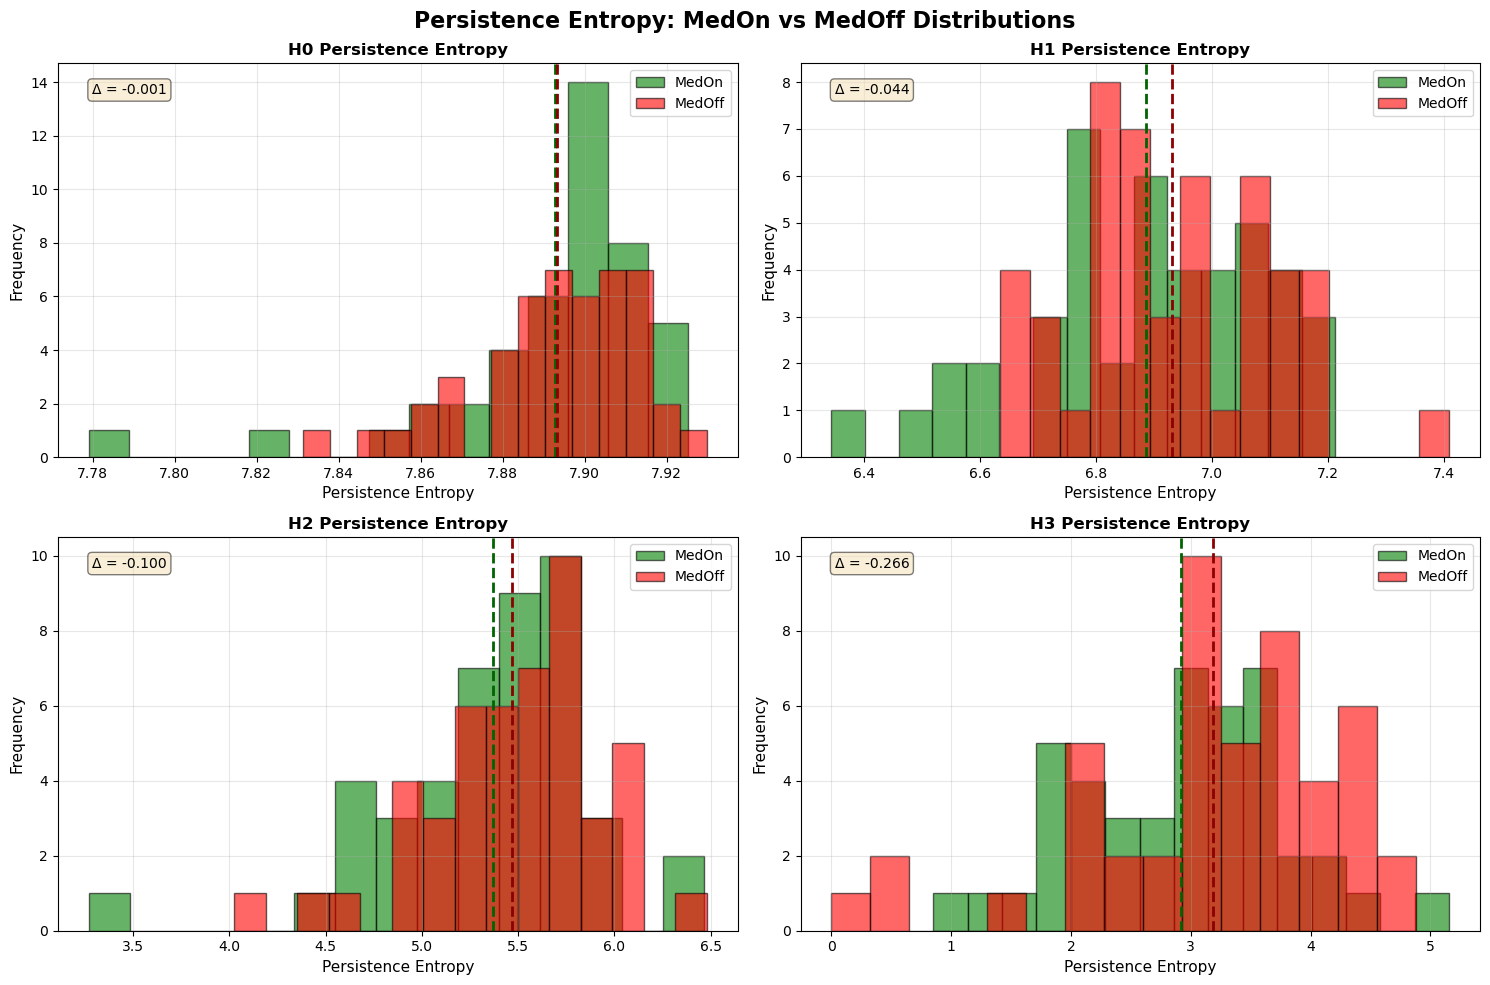


Persistence Entropy: MedOn vs MedOff Comparison

H0:
  MedOn  - Mean: 7.8927, Std: 0.0267
  MedOff - Mean: 7.8933, Std: 0.0205
  Difference: -0.0006

H1:
  MedOn  - Mean: 6.8864, Std: 0.2021
  MedOff - Mean: 6.9300, Std: 0.1731
  Difference: -0.0437

H2:
  MedOn  - Mean: 5.3681, Std: 0.5390
  MedOff - Mean: 5.4678, Std: 0.4618
  Difference: -0.0997

H3:
  MedOn  - Mean: 2.9160, Std: 0.8767
  MedOff - Mean: 3.1823, Std: 1.0716
  Difference: -0.2663


In [56]:
# Compare persistence entropy distributions between medOn and medOff
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Persistence Entropy: MedOn vs MedOff Distributions', fontsize=16, fontweight='bold')

entropy_features = ['h0_persistence_entropy', 'h1_persistence_entropy', 
                   'h2_persistence_entropy', 'h3_persistence_entropy']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(entropy_features, dims)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Separate data by medication state
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    # Plot overlapping histograms
    ax.hist(medOn_data, bins=15, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax.hist(medOff_data, bins=15, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    
    # Add mean lines
    ax.axvline(medOn_data.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax.axvline(medOff_data.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Persistence Entropy', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{dim} Persistence Entropy', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add text with mean difference
    diff = medOn_data.mean() - medOff_data.mean()
    ax.text(0.05, 0.95, f'Δ = {diff:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nPersistence Entropy: MedOn vs MedOff Comparison")
print("="*70)
for feature, dim in zip(entropy_features, dims):
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    print(f"\n{dim}:")
    print(f"  MedOn  - Mean: {medOn_data.mean():.4f}, Std: {medOn_data.std():.4f}")
    print(f"  MedOff - Mean: {medOff_data.mean():.4f}, Std: {medOff_data.std():.4f}")
    print(f"  Difference: {medOn_data.mean() - medOff_data.mean():.4f}")

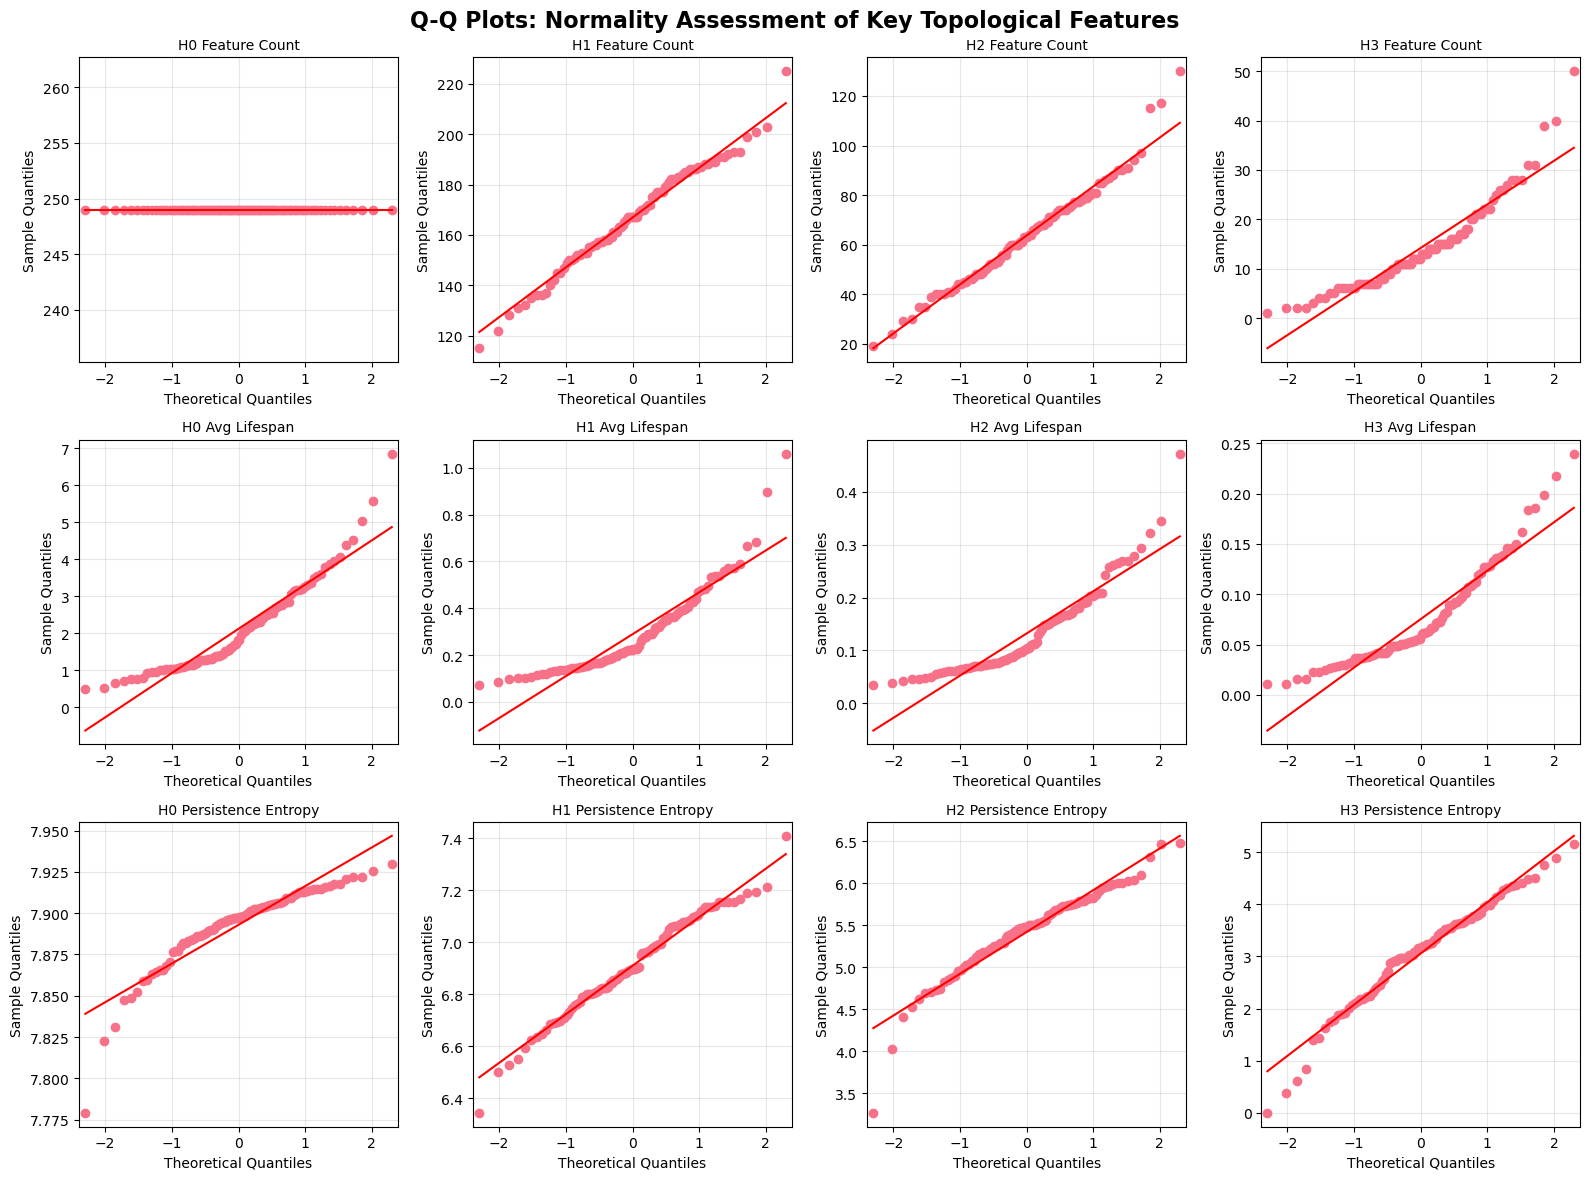


Q-Q Plot Interpretation:
If points fall along the diagonal line, the data follows a normal distribution.
Deviations from the line indicate departures from normality.
  - S-shaped curve: Heavy tails
  - Inverse S-curve: Light tails
  - Points above line at ends: Right skew
  - Points below line at ends: Left skew


In [57]:
# Q-Q Plots to assess normality of key features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment of Key Topological Features', 
             fontsize=16, fontweight='bold')

# Select key features for normality testing
test_features = [
    'h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count',
    'h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan',
    'h0_persistence_entropy', 'h1_persistence_entropy', 'h2_persistence_entropy', 'h3_persistence_entropy'
]

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot
    sm.qqplot(df_all[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nQ-Q Plot Interpretation:")
print("="*70)
print("If points fall along the diagonal line, the data follows a normal distribution.")
print("Deviations from the line indicate departures from normality.")
print("  - S-shaped curve: Heavy tails")
print("  - Inverse S-curve: Light tails")
print("  - Points above line at ends: Right skew")
print("  - Points below line at ends: Left skew")

In [58]:
# Statistical tests for normality
print("Shapiro-Wilk Normality Tests")
print("="*70)
print("Null hypothesis: Data is normally distributed")
print("If p-value < 0.05, reject null hypothesis (data is NOT normal)")
print("="*70)

normality_results = []

for feature in test_features:
    # Shapiro-Wilk test
    statistic, p_value = shapiro(df_all[feature].dropna())
    
    # Determine if normal
    is_normal = "Yes" if p_value > 0.05 else "No"
    
    normality_results.append({
        'Feature': feature,
        'Statistic': statistic,
        'p-value': p_value,
        'Normal (α=0.05)': is_normal
    })

# Create DataFrame for better display
normality_df = pd.DataFrame(normality_results)
normality_df = normality_df.sort_values('p-value')

print("\n")
display(normality_df)

# Summary
n_normal = (normality_df['Normal (α=0.05)'] == 'Yes').sum()
n_total = len(normality_df)

print(f"\n{'='*70}")
print(f"Summary: {n_normal}/{n_total} features appear normally distributed (α=0.05)")
print(f"{'='*70}")

if n_normal < n_total:
    print("\nNote: Some features are not normally distributed.")
    print("Consider using:")
    print("  - Non-parametric tests (Wilcoxon instead of paired t-test)")
    print("  - Transformation (log, Box-Cox) before parametric tests")
    print("  - Robust statistical methods")

Shapiro-Wilk Normality Tests
Null hypothesis: Data is normally distributed
If p-value < 0.05, reject null hypothesis (data is NOT normal)




,Feature,Statistic,p-value,Normal (α=0.05)
5,h1_avg_lifespan,0.857,5.677e-08,No
8,h0_persistence_entropy,0.863,9.996e-08,No
6,h2_avg_lifespan,0.870,1.881e-07,No
7,h3_avg_lifespan,0.892,1.476e-06,No
4,h0_avg_lifespan,0.903,4.709e-06,No
3,h3_feature_count,0.904,5.129e-06,No
10,h2_persistence_entropy,0.945,6.958e-04,No
11,h3_persistence_entropy,0.972,4.509e-02,No
2,h2_feature_count,0.979,1.377e-01,Yes
9,h1_persistence_entropy,0.986,4.308e-01,Yes



Summary: 4/12 features appear normally distributed (α=0.05)

Note: Some features are not normally distributed.
Consider using:
  - Non-parametric tests (Wilcoxon instead of paired t-test)
  - Transformation (log, Box-Cox) before parametric tests
  - Robust statistical methods


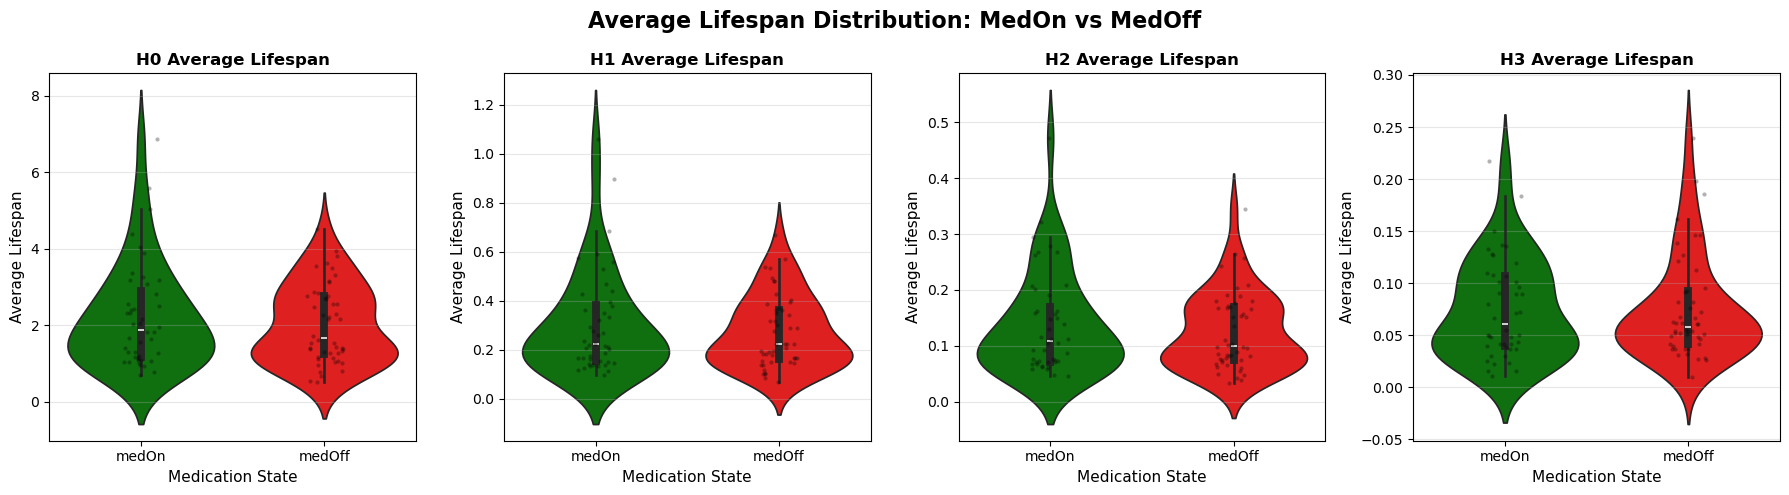


Average Lifespan: MedOn vs MedOff Summary

H0:
  MedOn  - Mean: 2.2328, Median: 1.8801
  MedOff - Mean: 2.0199, Median: 1.6666
  Difference (Mean): 0.2129
  Difference (Median): 0.2135

H1:
  MedOn  - Mean: 0.3057, Median: 0.2231
  MedOff - Mean: 0.2744, Median: 0.2245
  Difference (Mean): 0.0313
  Difference (Median): -0.0014

H2:
  MedOn  - Mean: 0.1391, Median: 0.1085
  MedOff - Mean: 0.1257, Median: 0.0990
  Difference (Mean): 0.0135
  Difference (Median): 0.0095

H3:
  MedOn  - Mean: 0.0753, Median: 0.0606
  MedOff - Mean: 0.0752, Median: 0.0578
  Difference (Mean): 0.0001
  Difference (Median): 0.0028


In [59]:
# Violin plots for average lifespan features (medOn vs medOff)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Average Lifespan Distribution: MedOn vs MedOff', fontsize=16, fontweight='bold')

lifespan_features = ['h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(lifespan_features, dims)):
    ax = axes[idx]
    
    # Create violin plot
    sns.violinplot(data=df_all, x='med_state', y=feature, ax=ax, palette=['green', 'red'])
    
    # Add individual points
    sns.stripplot(data=df_all, x='med_state', y=feature, ax=ax, 
                  color='black', alpha=0.3, size=3)
    
    ax.set_xlabel('Medication State', fontsize=11)
    ax.set_ylabel('Average Lifespan', fontsize=11)
    ax.set_title(f'{dim} Average Lifespan', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nAverage Lifespan: MedOn vs MedOff Summary")
print("="*70)
for feature, dim in zip(lifespan_features, dims):
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    print(f"\n{dim}:")
    print(f"  MedOn  - Mean: {medOn_data.mean():.4f}, Median: {medOn_data.median():.4f}")
    print(f"  MedOff - Mean: {medOff_data.mean():.4f}, Median: {medOff_data.median():.4f}")
    print(f"  Difference (Mean): {medOn_data.mean() - medOff_data.mean():.4f}")
    print(f"  Difference (Median): {medOn_data.median() - medOff_data.median():.4f}")

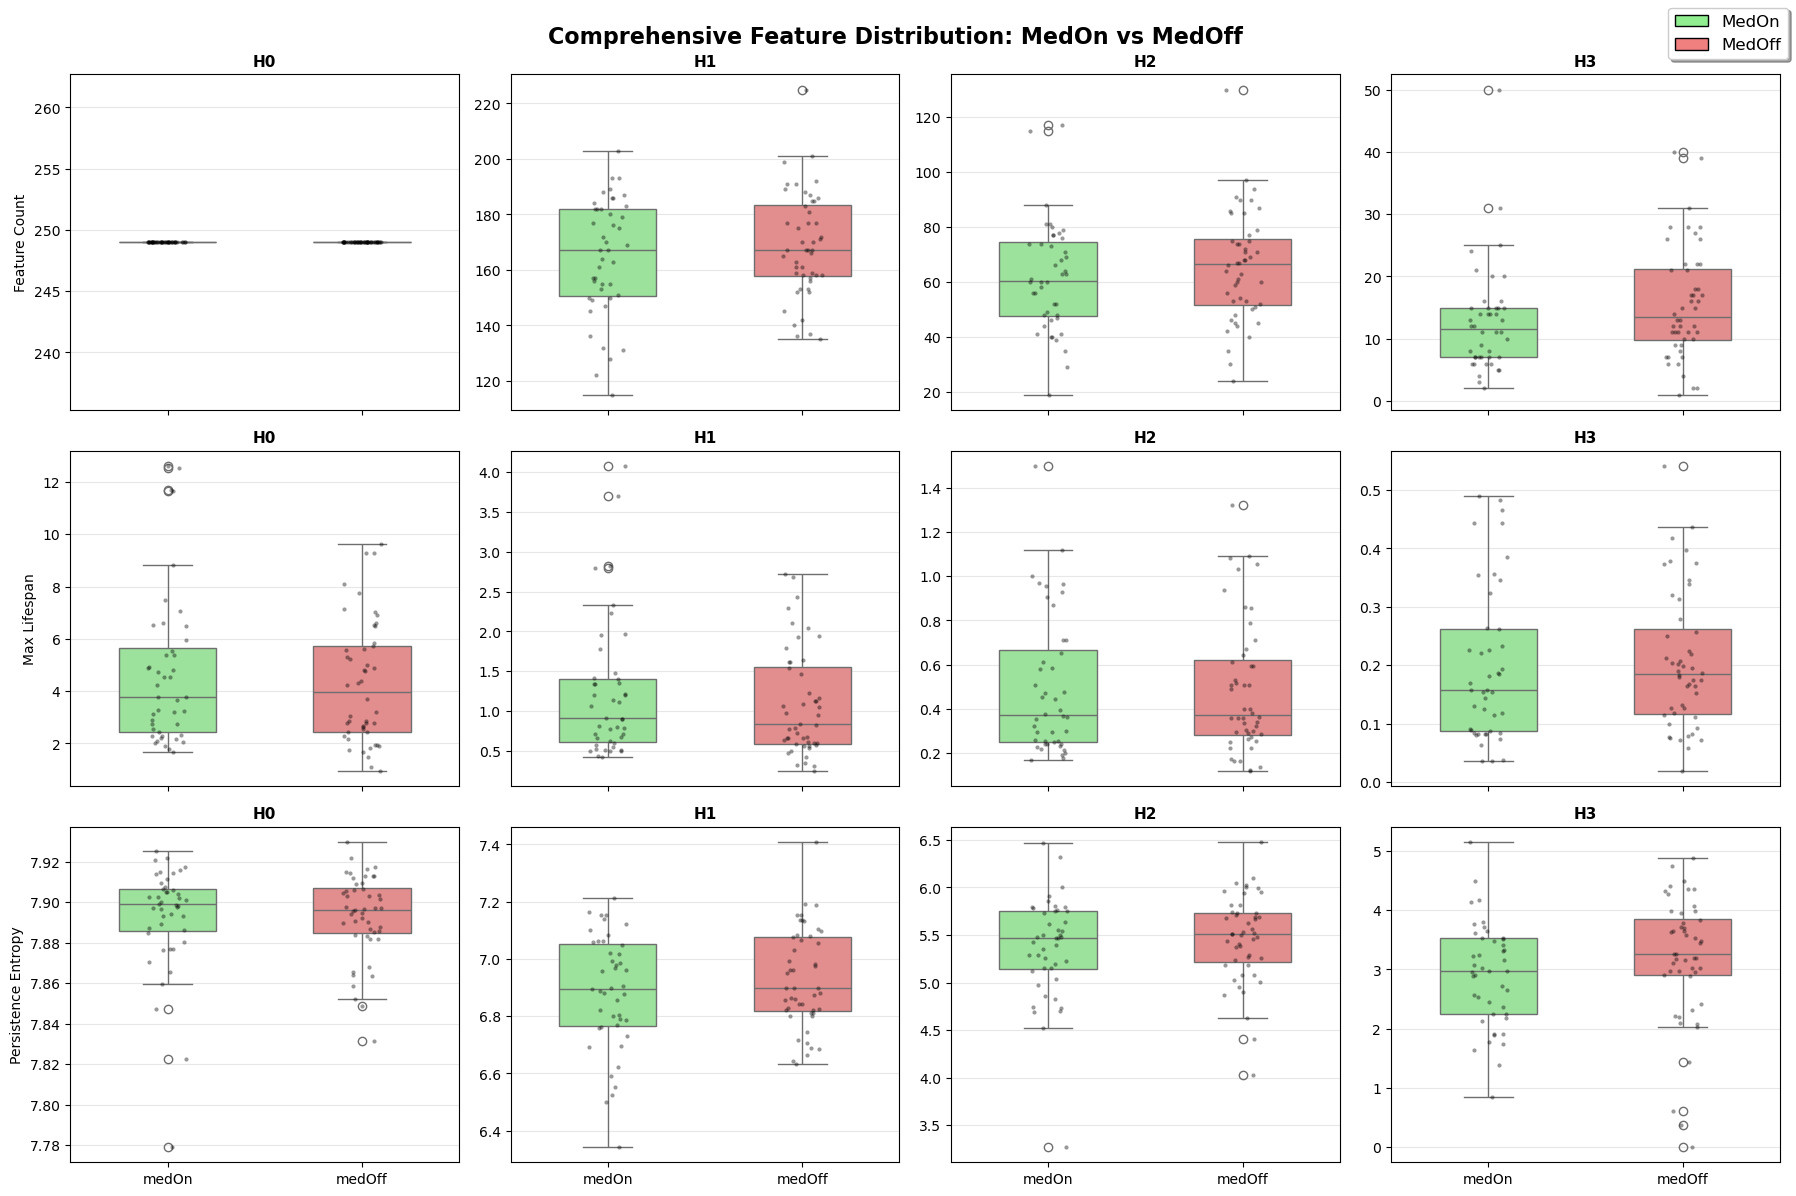


Key Observations from Box Plots:
Box plot components:
  - Box: Interquartile range (25th to 75th percentile)
  - Line in box: Median
  - Whiskers: Data range (excluding outliers)
  - Individual points: All data points (shows variability)

Look for:
  - Separation between medOn and medOff boxes
  - Overlap of boxes (less overlap = more discriminative)
  - Outliers (points far from whiskers)


In [60]:
# Comprehensive box plot comparison across feature types
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('Comprehensive Feature Distribution: MedOn vs MedOff', 
             fontsize=16, fontweight='bold')

# Three feature types across four homology dimensions
feature_groups = {
    'Feature Count': ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count'],
    'Max Lifespan': ['h0_max_lifespan', 'h1_max_lifespan', 'h2_max_lifespan', 'h3_max_lifespan'],
    'Persistence Entropy': ['h0_persistence_entropy', 'h1_persistence_entropy', 
                           'h2_persistence_entropy', 'h3_persistence_entropy']
}

dims = ['H0', 'H1', 'H2', 'H3']

for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = axes[row_idx, col_idx]
        
        # Create box plot with overlay of individual points
        sns.boxplot(data=df_all, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_all, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=3)
        
        # Formatting
        ax.set_xlabel('')
        ax.set_ylabel(group_name if col_idx == 0 else '', fontsize=10)
        ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Only show x-axis labels on bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='MedOn'),
    Patch(facecolor='lightcoral', edgecolor='black', label='MedOff')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=12, 
          frameon=True, shadow=True)

plt.tight_layout()
plt.show()

print("\nKey Observations from Box Plots:")
print("="*70)
print("Box plot components:")
print("  - Box: Interquartile range (25th to 75th percentile)")
print("  - Line in box: Median")
print("  - Whiskers: Data range (excluding outliers)")
print("  - Individual points: All data points (shows variability)")
print("\nLook for:")
print("  - Separation between medOn and medOff boxes")
print("  - Overlap of boxes (less overlap = more discriminative)")
print("  - Outliers (points far from whiskers)")

### Distribution Analysis Summary (Brain hemispheres pooled)

Based on the visualizations and statistical tests above, key observations:

#### Data Quality
- ✓ No missing values in any features
- ✓ All features have reasonable ranges
- ✓ Data loaded successfully for all 14 patients (92 observations total)

#### Normality Assessment
- Some features show departures from normality (see Shapiro-Wilk results)
- Q-Q plots reveal the extent of deviation for each feature
- Normally distributed features: H2 feature count, H1 Persistence Entropy, H1 Feature count, H0 Feature count(constant, std=0)
- **Implication**: May need to use non-parametric tests (Wilcoxon) for features that violate normality

#### MedOn vs MedOff Patterns
Visual inspection suggests:
- **Feature counts** (H0-H3): Check for consistent differences between medication states
- **Lifespans**: Examine which dimensions show most separation
- **Persistence entropy**: Look for clear medOn/medOff separation in distributions

#### Next Steps
1. Quantify these visual differences with statistical tests (paired t-tests)
2. Calculate effect sizes to determine practical significance
3. Identify which features are most discriminative
4. Examine correlations between features
5. Use PCA to visualize high-dimensional structure

**Note**: These are preliminary observations. Formal statistical testing will determine significance.

## Hemisphere-Specific Distribution Analysis

The previous analysis pooled data across both hemispheres. Now we examine **dominant vs nondominant hemisphere** separately to detect potential lateralization effects.

**Hemisphere mapping** (based on contralateral motor control):
- **holdL patients**: Right hemisphere = dominant (controls left arm)
- **holdR patients**: Left hemisphere = dominant (controls right arm)

This analysis will reveal whether medication effects are:
- **Lateralized**: Different in dominant vs nondominant hemisphere
- **Symmetric**: Similar across both hemispheres

In [61]:
# Separate data by hemisphere
df_dominant = df_all[df_all['hemisphere'] == 'dominant'].copy()
df_nondominant = df_all[df_all['hemisphere'] == 'nondominant'].copy()

print("Hemisphere-Specific Data Summary")
print("="*70)
print(f"Dominant hemisphere observations: {len(df_dominant)}")
print(f"  MedOn: {len(df_dominant[df_dominant['med_state'] == 'medOn'])}")
print(f"  MedOff: {len(df_dominant[df_dominant['med_state'] == 'medOff'])}")
print(f"\nNondominant hemisphere observations: {len(df_nondominant)}")
print(f"  MedOn: {len(df_nondominant[df_nondominant['med_state'] == 'medOn'])}")
print(f"  MedOff: {len(df_nondominant[df_nondominant['med_state'] == 'medOff'])}")
print(f"\nTotal observations: {len(df_all)}")
print("="*70)

Hemisphere-Specific Data Summary
Dominant hemisphere observations: 46
  MedOn: 22
  MedOff: 24

Nondominant hemisphere observations: 46
  MedOn: 22
  MedOff: 24

Total observations: 92


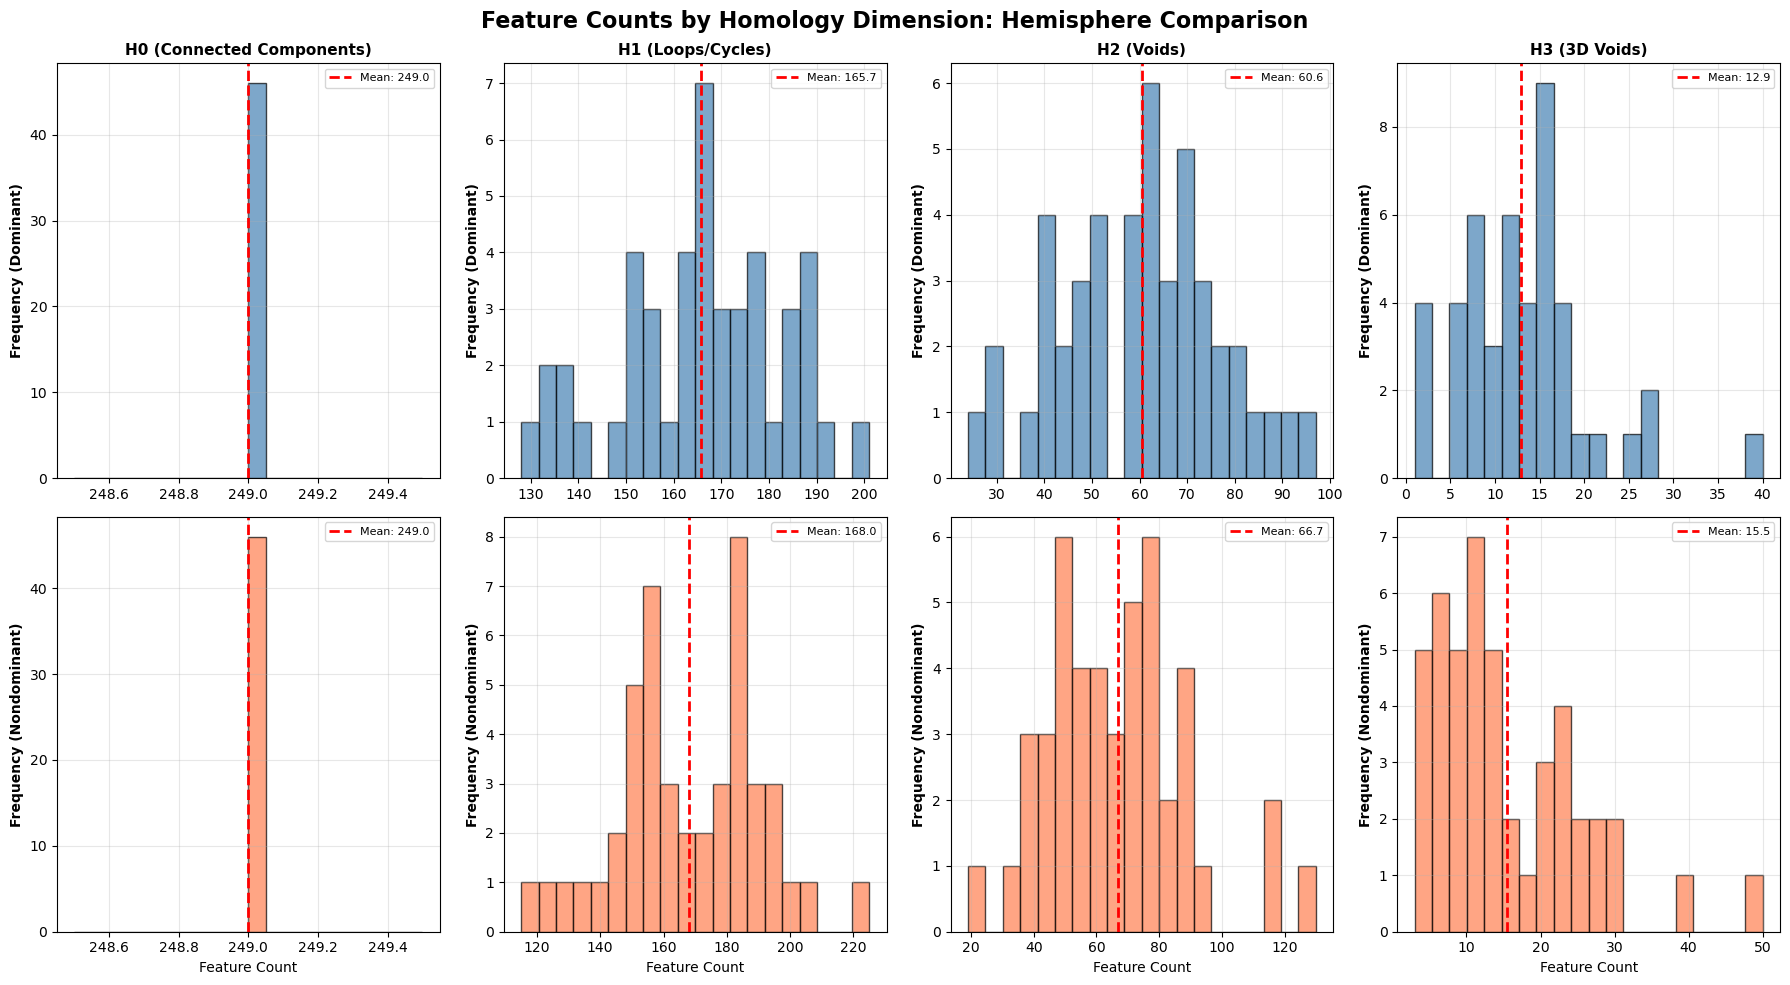


Feature Count Statistics: Dominant vs Nondominant Hemisphere

H0 (Connected Components):
  Dominant    - Mean: 249.00, Std: 0.00
  Nondominant - Mean: 249.00, Std: 0.00
  Difference: 0.00

H1 (Loops/Cycles):
  Dominant    - Mean: 165.72, Std: 17.12
  Nondominant - Mean: 168.04, Std: 22.42
  Difference: -2.33

H2 (Voids):
  Dominant    - Mean: 60.61, Std: 16.92
  Nondominant - Mean: 66.74, Std: 22.25
  Difference: -6.13

H3 (3D Voids):
  Dominant    - Mean: 12.93, Std: 7.50
  Nondominant - Mean: 15.46, Std: 9.99
  Difference: -2.52


In [62]:
# Feature counts by hemisphere - Side by side comparison
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Feature Counts by Homology Dimension: Hemisphere Comparison', 
             fontsize=16, fontweight='bold')

count_features = ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count']
dims = ['H0 (Connected Components)', 'H1 (Loops/Cycles)', 'H2 (Voids)', 'H3 (3D Voids)']

for idx, (feature, dim_name) in enumerate(zip(count_features, dims)):
    # Dominant hemisphere (top row)
    ax_dom = axes[0, idx]
    ax_dom.hist(df_dominant[feature], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    ax_dom.axvline(df_dominant[feature].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_dominant[feature].mean():.1f}')
    ax_dom.set_ylabel('Frequency (Dominant)', fontsize=10, fontweight='bold')
    ax_dom.set_title(f'{dim_name}', fontsize=11, fontweight='bold')
    ax_dom.legend(fontsize=8)
    ax_dom.grid(True, alpha=0.3)
    
    # Nondominant hemisphere (bottom row)
    ax_nondom = axes[1, idx]
    ax_nondom.hist(df_nondominant[feature], bins=20, alpha=0.7, color='coral', edgecolor='black')
    ax_nondom.axvline(df_nondominant[feature].mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {df_nondominant[feature].mean():.1f}')
    ax_nondom.set_xlabel('Feature Count', fontsize=10)
    ax_nondom.set_ylabel('Frequency (Nondominant)', fontsize=10, fontweight='bold')
    ax_nondom.legend(fontsize=8)
    ax_nondom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nFeature Count Statistics: Dominant vs Nondominant Hemisphere")
print("="*70)
for feature, dim_name in zip(count_features, dims):
    print(f"\n{dim_name}:")
    print(f"  Dominant    - Mean: {df_dominant[feature].mean():.2f}, Std: {df_dominant[feature].std():.2f}")
    print(f"  Nondominant - Mean: {df_nondominant[feature].mean():.2f}, Std: {df_nondominant[feature].std():.2f}")
    print(f"  Difference: {df_dominant[feature].mean() - df_nondominant[feature].mean():.2f}")

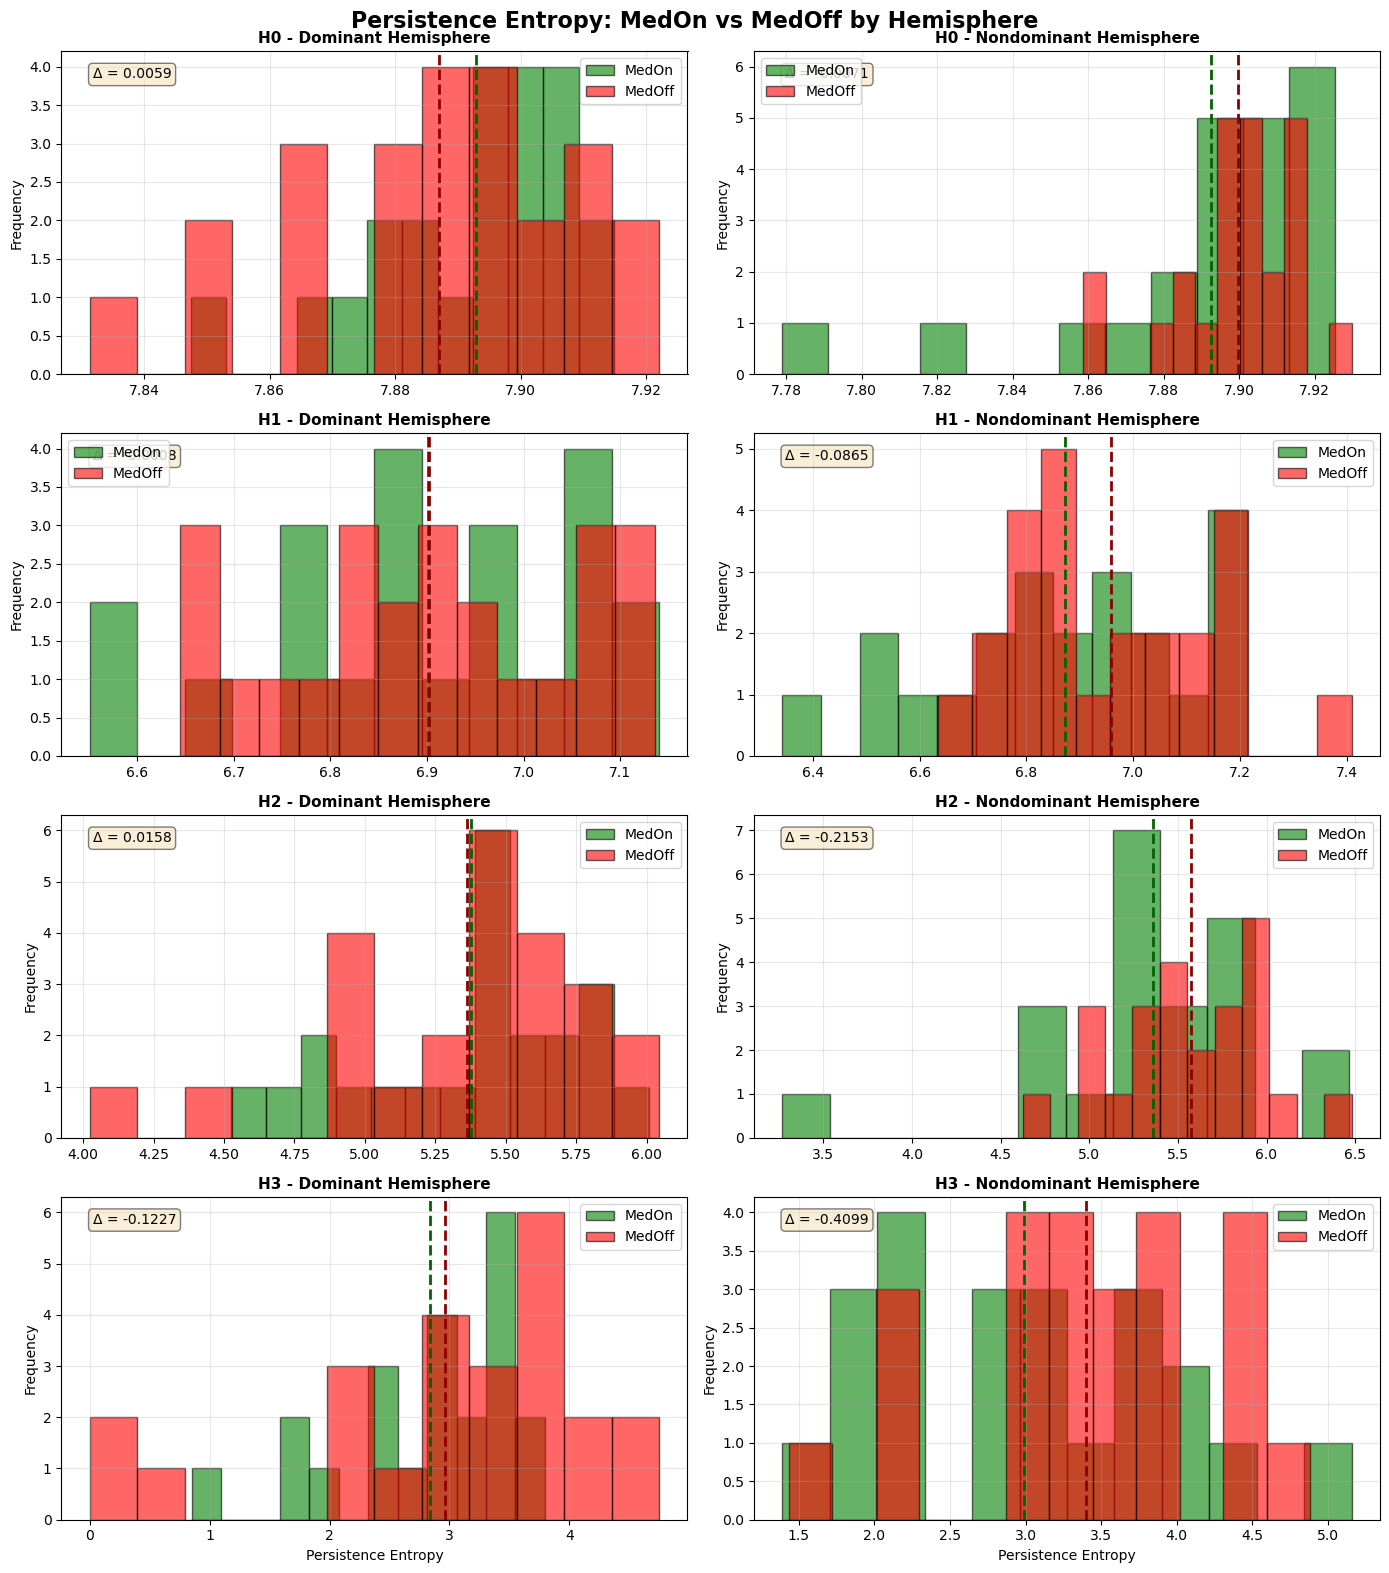


Persistence Entropy: MedOn vs MedOff by Hemisphere

H0:
  DOMINANT Hemisphere:
    MedOn  - Mean: 7.8929, Std: 0.0166
    MedOff - Mean: 7.8869, Std: 0.0227
    Difference: 0.0059
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 7.8924, Std: 0.0344
    MedOff - Mean: 7.8996, Std: 0.0163
    Difference: -0.0071

H1:
  DOMINANT Hemisphere:
    MedOn  - Mean: 6.9008, Std: 0.1628
    MedOff - Mean: 6.9016, Std: 0.1517
    Difference: -0.0008
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 6.8720, Std: 0.2382
    MedOff - Mean: 6.9585, Std: 0.1912
    Difference: -0.0865

H2:
  DOMINANT Hemisphere:
    MedOn  - Mean: 5.3783, Std: 0.4071
    MedOff - Mean: 5.3625, Std: 0.4801
    Difference: 0.0158
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 5.3579, Std: 0.6550
    MedOff - Mean: 5.5732, Std: 0.4267
    Difference: -0.2153

H3:
  DOMINANT Hemisphere:
    MedOn  - Mean: 2.8395, Std: 0.7610
    MedOff - Mean: 2.9622, Std: 1.2328
    Difference: -0.1227
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 2

In [63]:
# Persistence Entropy: MedOn vs MedOff by Hemisphere
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle('Persistence Entropy: MedOn vs MedOff by Hemisphere', 
             fontsize=16, fontweight='bold')

entropy_features = ['h0_persistence_entropy', 'h1_persistence_entropy', 
                   'h2_persistence_entropy', 'h3_persistence_entropy']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(entropy_features, dims)):
    # Dominant hemisphere (left column)
    ax_dom = axes[idx, 0]
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    
    ax_dom.hist(medOn_dom, bins=12, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax_dom.hist(medOff_dom, bins=12, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    ax_dom.axvline(medOn_dom.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax_dom.axvline(medOff_dom.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax_dom.set_ylabel('Frequency', fontsize=10)
    ax_dom.set_title(f'{dim} - Dominant Hemisphere', fontsize=11, fontweight='bold')
    ax_dom.legend()
    ax_dom.grid(True, alpha=0.3)
    
    diff_dom = medOn_dom.mean() - medOff_dom.mean()
    ax_dom.text(0.05, 0.95, f'Δ = {diff_dom:.4f}', transform=ax_dom.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Nondominant hemisphere (right column)
    ax_nondom = axes[idx, 1]
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    
    ax_nondom.hist(medOn_nondom, bins=12, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax_nondom.hist(medOff_nondom, bins=12, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    ax_nondom.axvline(medOn_nondom.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax_nondom.axvline(medOff_nondom.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax_nondom.set_ylabel('Frequency', fontsize=10)
    ax_nondom.set_title(f'{dim} - Nondominant Hemisphere', fontsize=11, fontweight='bold')
    ax_nondom.legend()
    ax_nondom.grid(True, alpha=0.3)
    
    diff_nondom = medOn_nondom.mean() - medOff_nondom.mean()
    ax_nondom.text(0.05, 0.95, f'Δ = {diff_nondom:.4f}', transform=ax_nondom.transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Set x-label only for bottom row
axes[3, 0].set_xlabel('Persistence Entropy', fontsize=10)
axes[3, 1].set_xlabel('Persistence Entropy', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nPersistence Entropy: MedOn vs MedOff by Hemisphere")
print("="*70)
for feature, dim in zip(entropy_features, dims):
    print(f"\n{dim}:")
    
    # Dominant hemisphere
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    print(f"  DOMINANT Hemisphere:")
    print(f"    MedOn  - Mean: {medOn_dom.mean():.4f}, Std: {medOn_dom.std():.4f}")
    print(f"    MedOff - Mean: {medOff_dom.mean():.4f}, Std: {medOff_dom.std():.4f}")
    print(f"    Difference: {medOn_dom.mean() - medOff_dom.mean():.4f}")
    
    # Nondominant hemisphere
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    print(f"  NONDOMINANT Hemisphere:")
    print(f"    MedOn  - Mean: {medOn_nondom.mean():.4f}, Std: {medOn_nondom.std():.4f}")
    print(f"    MedOff - Mean: {medOff_nondom.mean():.4f}, Std: {medOff_nondom.std():.4f}")
    print(f"    Difference: {medOn_nondom.mean() - medOff_nondom.mean():.4f}")

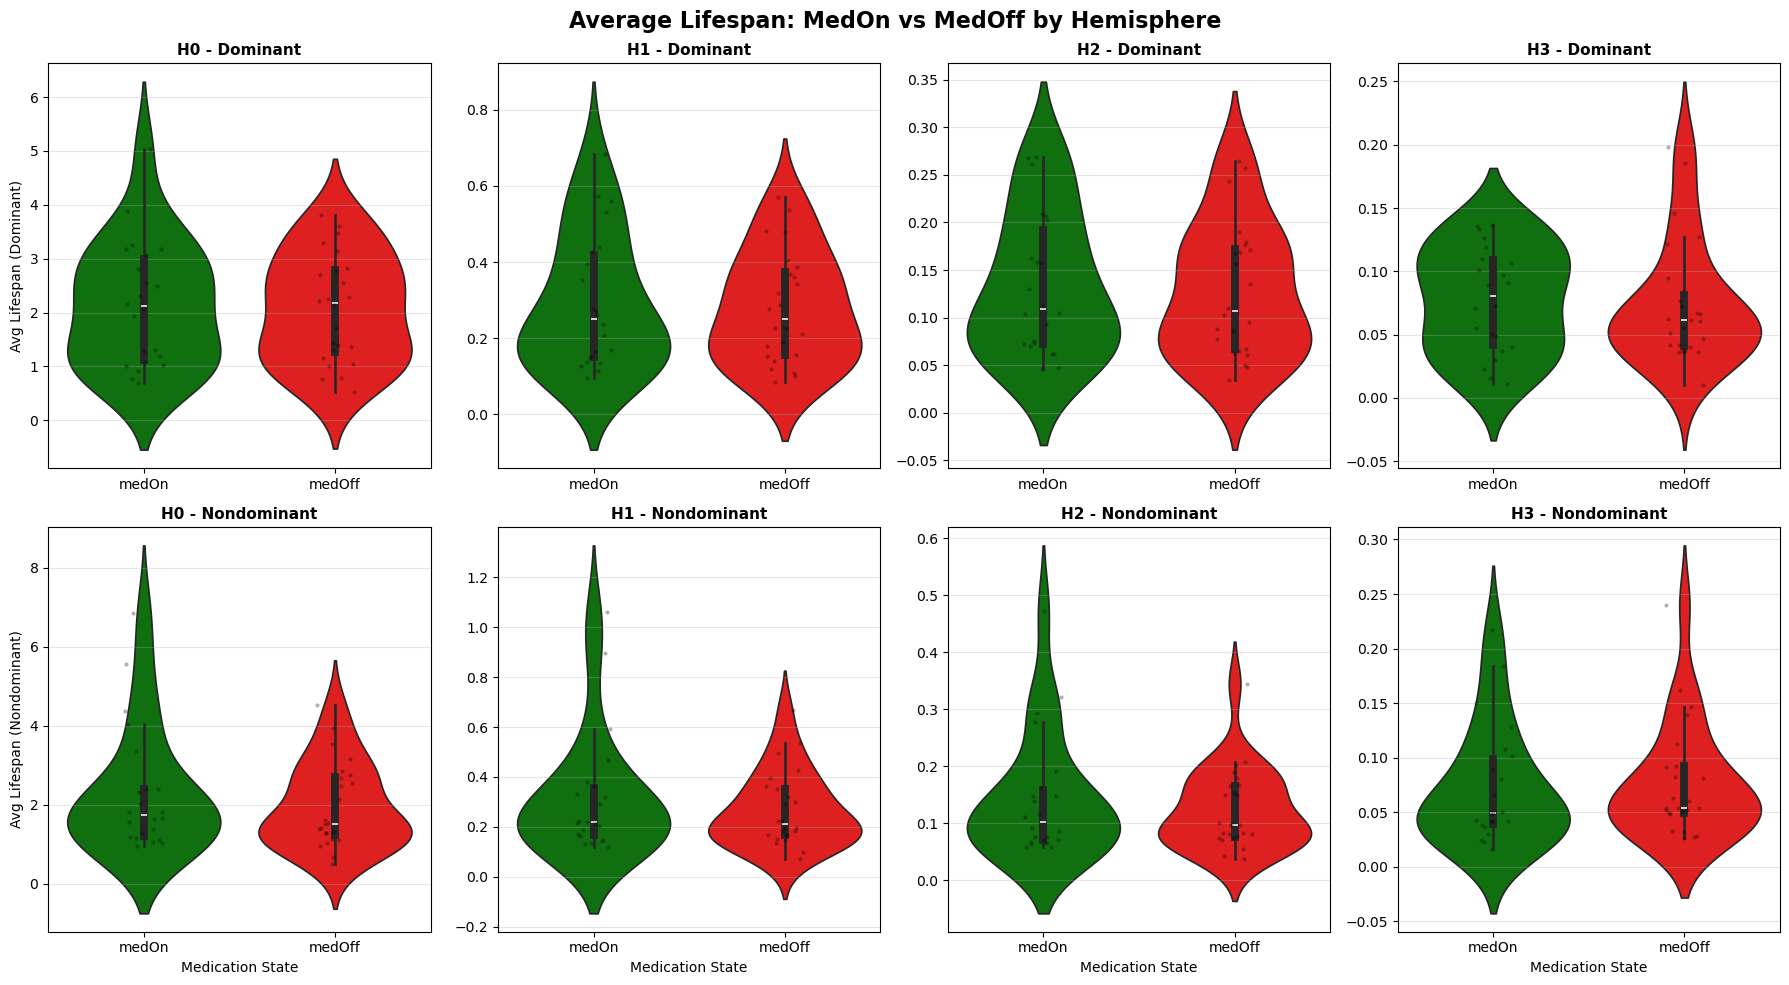


Average Lifespan: MedOn vs MedOff by Hemisphere

H0:
  DOMINANT:
    MedOn  - Mean: 2.1481, Median: 2.1141
    MedOff - Mean: 2.0676, Median: 2.1815
    Difference: 0.0806
  NONDOMINANT:
    MedOn  - Mean: 2.3175, Median: 1.7401
    MedOff - Mean: 1.9723, Median: 1.5210
    Difference: 0.3452

H1:
  DOMINANT:
    MedOn  - Mean: 0.2935, Median: 0.2495
    MedOff - Mean: 0.2795, Median: 0.2506
    Difference: 0.0140
  NONDOMINANT:
    MedOn  - Mean: 0.3178, Median: 0.2182
    MedOff - Mean: 0.2692, Median: 0.2102
    Difference: 0.0486

H2:
  DOMINANT:
    MedOn  - Mean: 0.1340, Median: 0.1089
    MedOff - Mean: 0.1275, Median: 0.1065
    Difference: 0.0065
  NONDOMINANT:
    MedOn  - Mean: 0.1443, Median: 0.1020
    MedOff - Mean: 0.1239, Median: 0.0971
    Difference: 0.0204

H3:
  DOMINANT:
    MedOn  - Mean: 0.0773, Median: 0.0809
    MedOff - Mean: 0.0740, Median: 0.0614
    Difference: 0.0033
  NONDOMINANT:
    MedOn  - Mean: 0.0732, Median: 0.0489
    MedOff - Mean: 0.0764, Media

In [64]:
# Violin plots: Average Lifespan by Hemisphere
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Average Lifespan: MedOn vs MedOff by Hemisphere', fontsize=16, fontweight='bold')

lifespan_features = ['h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(lifespan_features, dims)):
    # Dominant hemisphere (top row)
    ax_dom = axes[0, idx]
    sns.violinplot(data=df_dominant, x='med_state', y=feature, ax=ax_dom, palette=['green', 'red'])
    sns.stripplot(data=df_dominant, x='med_state', y=feature, ax=ax_dom, 
                  color='black', alpha=0.3, size=3)
    ax_dom.set_xlabel('')
    ax_dom.set_ylabel('Avg Lifespan (Dominant)' if idx == 0 else '', fontsize=10)
    ax_dom.set_title(f'{dim} - Dominant', fontsize=11, fontweight='bold')
    ax_dom.grid(True, alpha=0.3, axis='y')
    
    # Nondominant hemisphere (bottom row)
    ax_nondom = axes[1, idx]
    sns.violinplot(data=df_nondominant, x='med_state', y=feature, ax=ax_nondom, palette=['green', 'red'])
    sns.stripplot(data=df_nondominant, x='med_state', y=feature, ax=ax_nondom, 
                  color='black', alpha=0.3, size=3)
    ax_nondom.set_xlabel('Medication State', fontsize=10)
    ax_nondom.set_ylabel('Avg Lifespan (Nondominant)' if idx == 0 else '', fontsize=10)
    ax_nondom.set_title(f'{dim} - Nondominant', fontsize=11, fontweight='bold')
    ax_nondom.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison
print("\nAverage Lifespan: MedOn vs MedOff by Hemisphere")
print("="*70)
for feature, dim in zip(lifespan_features, dims):
    print(f"\n{dim}:")
    
    # Dominant
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    print(f"  DOMINANT:")
    print(f"    MedOn  - Mean: {medOn_dom.mean():.4f}, Median: {medOn_dom.median():.4f}")
    print(f"    MedOff - Mean: {medOff_dom.mean():.4f}, Median: {medOff_dom.median():.4f}")
    print(f"    Difference: {medOn_dom.mean() - medOff_dom.mean():.4f}")
    
    # Nondominant
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    print(f"  NONDOMINANT:")
    print(f"    MedOn  - Mean: {medOn_nondom.mean():.4f}, Median: {medOn_nondom.median():.4f}")
    print(f"    MedOff - Mean: {medOff_nondom.mean():.4f}, Median: {medOff_nondom.median():.4f}")
    print(f"    Difference: {medOn_nondom.mean() - medOff_nondom.mean():.4f}")

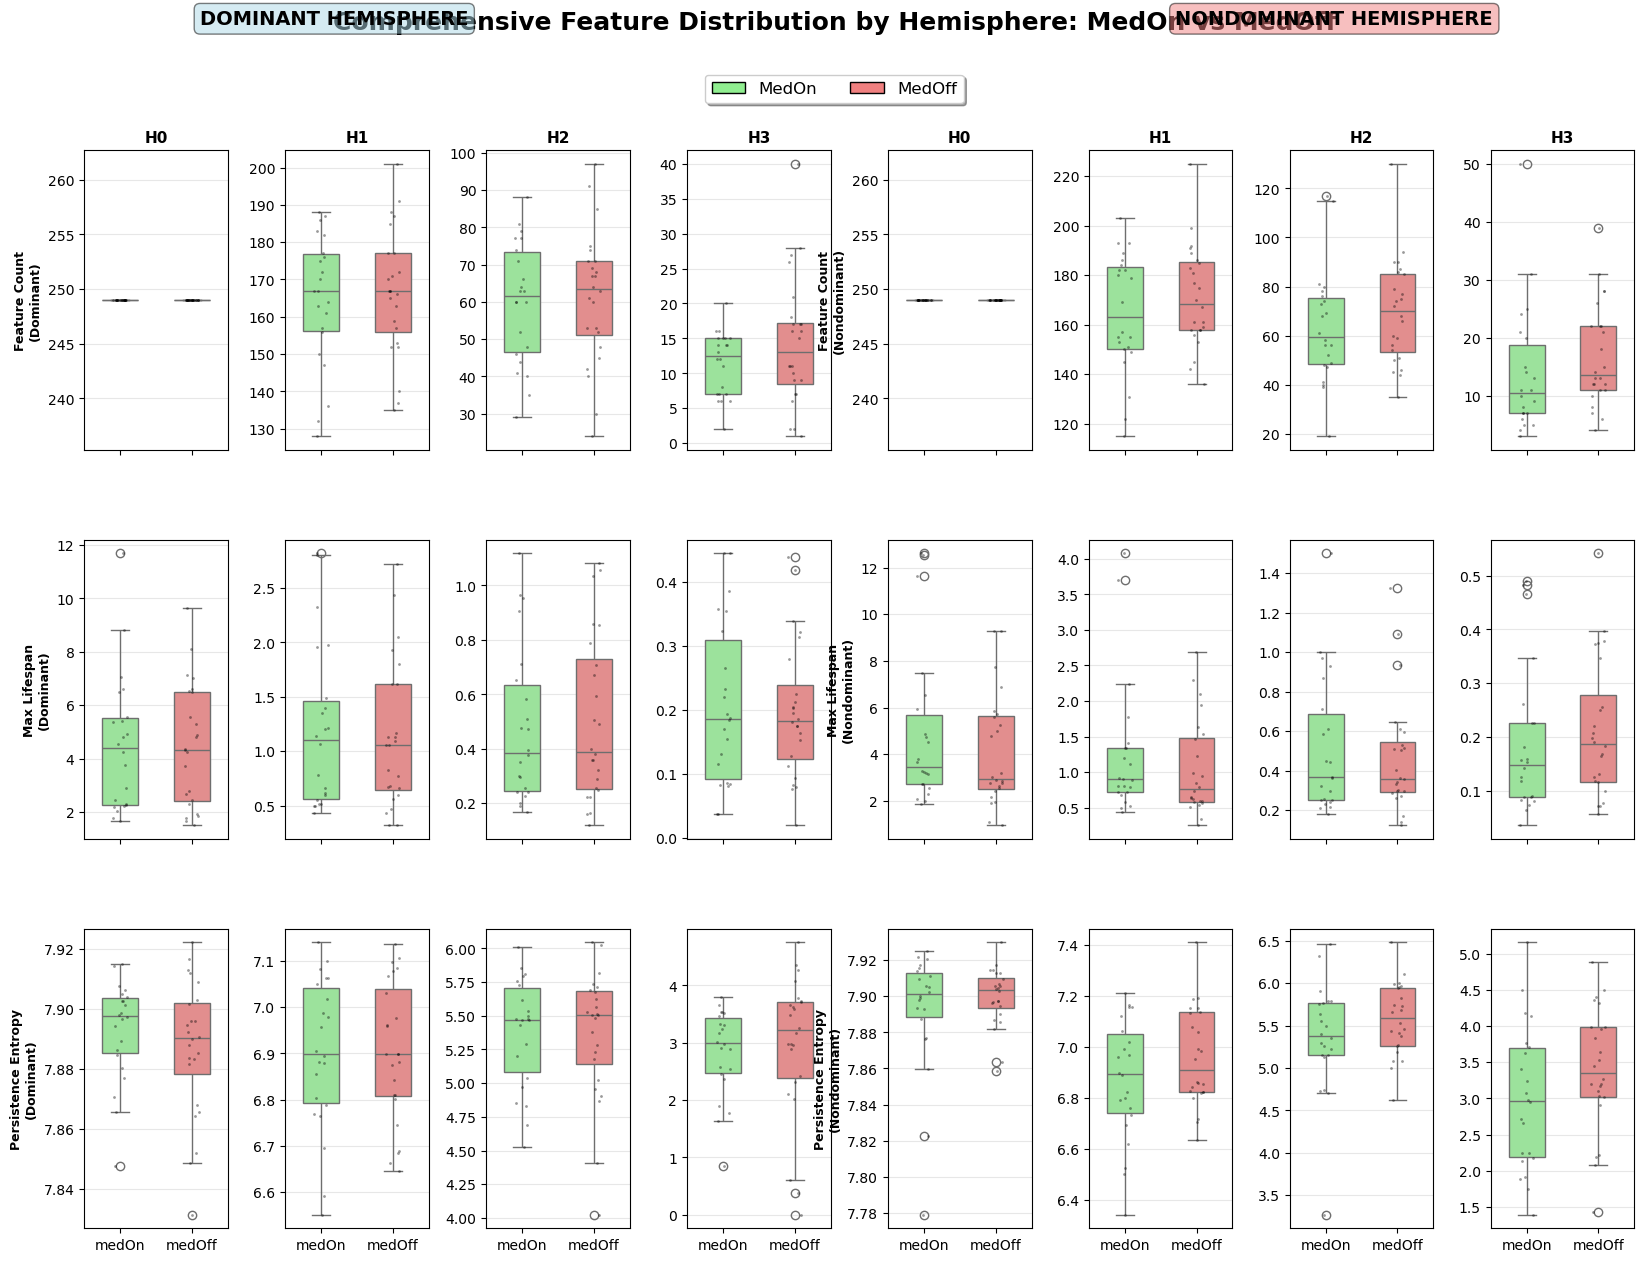


Hemisphere-Specific Box Plot Analysis Complete
Left panel: DOMINANT hemisphere
Right panel: NONDOMINANT hemisphere

Look for:
  - Consistent medOn/medOff differences across both hemispheres (symmetric effect)
  - Differences only in one hemisphere (lateralized effect)
  - Larger separation in dominant vs nondominant (motor-related lateralization)


In [65]:
# Comprehensive box plots by hemisphere - Two large panels
fig = plt.figure(figsize=(20, 14))
fig.suptitle('Comprehensive Feature Distribution by Hemisphere: MedOn vs MedOff', 
             fontsize=18, fontweight='bold')

# Feature groups
feature_groups = {
    'Feature Count': ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count'],
    'Max Lifespan': ['h0_max_lifespan', 'h1_max_lifespan', 'h2_max_lifespan', 'h3_max_lifespan'],
    'Persistence Entropy': ['h0_persistence_entropy', 'h1_persistence_entropy', 
                           'h2_persistence_entropy', 'h3_persistence_entropy']
}

dims = ['H0', 'H1', 'H2', 'H3']

# Create gridspec for better layout control
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 8, figure=fig, hspace=0.3, wspace=0.4)

# Dominant hemisphere (left 4 columns)
for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        
        # Box plot with points
        sns.boxplot(data=df_dominant, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_dominant, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=2)
        
        # Formatting
        ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(f'{group_name}\n(Dominant)', fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Title only on top row
        if row_idx == 0:
            ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        else:
            ax.set_title('')
            
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove x-axis labels except bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Nondominant hemisphere (right 4 columns)
for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = fig.add_subplot(gs[row_idx, col_idx + 4])
        
        # Box plot with points
        sns.boxplot(data=df_nondominant, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_nondominant, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=2)
        
        # Formatting
        ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(f'{group_name}\n(Nondominant)', fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Title only on top row
        if row_idx == 0:
            ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        else:
            ax.set_title('')
            
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove x-axis labels except bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Add hemisphere labels
fig.text(0.25, 0.97, 'DOMINANT HEMISPHERE', ha='center', fontsize=14, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.text(0.75, 0.97, 'NONDOMINANT HEMISPHERE', ha='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='MedOn'),
    Patch(facecolor='lightcoral', edgecolor='black', label='MedOff')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.94), 
          ncol=2, fontsize=12, frameon=True, shadow=True)

plt.show()

print("\nHemisphere-Specific Box Plot Analysis Complete")
print("="*70)
print("Left panel: DOMINANT hemisphere")
print("Right panel: NONDOMINANT hemisphere")
print("\nLook for:")
print("  - Consistent medOn/medOff differences across both hemispheres (symmetric effect)")
print("  - Differences only in one hemisphere (lateralized effect)")
print("  - Larger separation in dominant vs nondominant (motor-related lateralization)")

### Normality Assessment by Hemisphere

Since we've split the data by hemisphere (46 observations each), we need to assess normality separately for each subset. This is important because:
- Sample size is halved (could affect distributional properties)
- Hemispheres may have inherently different distributions
- Determines appropriate statistical tests for hemisphere-specific analyses

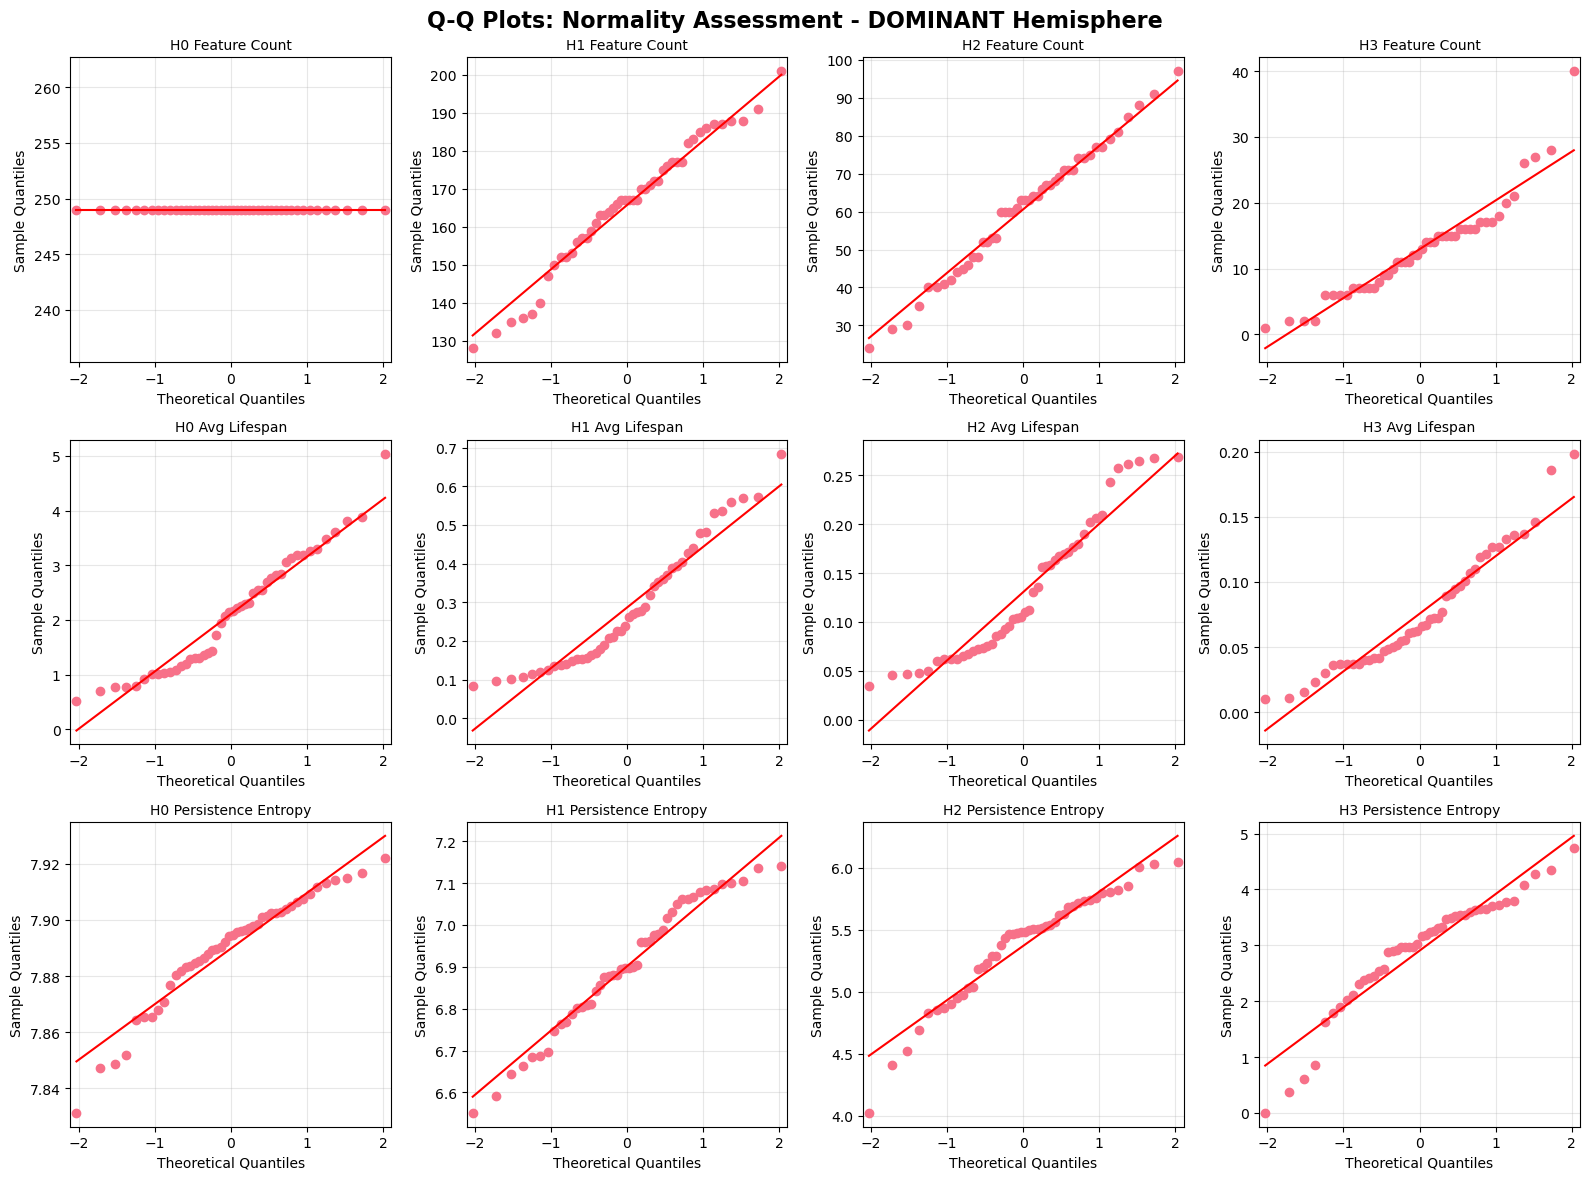

In [67]:
# Q-Q Plots for Dominant Hemisphere
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment - DOMINANT Hemisphere', 
             fontsize=16, fontweight='bold')

test_features = [
    'h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count',
    'h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan',
    'h0_persistence_entropy', 'h1_persistence_entropy', 'h2_persistence_entropy', 'h3_persistence_entropy'
]

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot for dominant hemisphere
    sm.qqplot(df_dominant[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

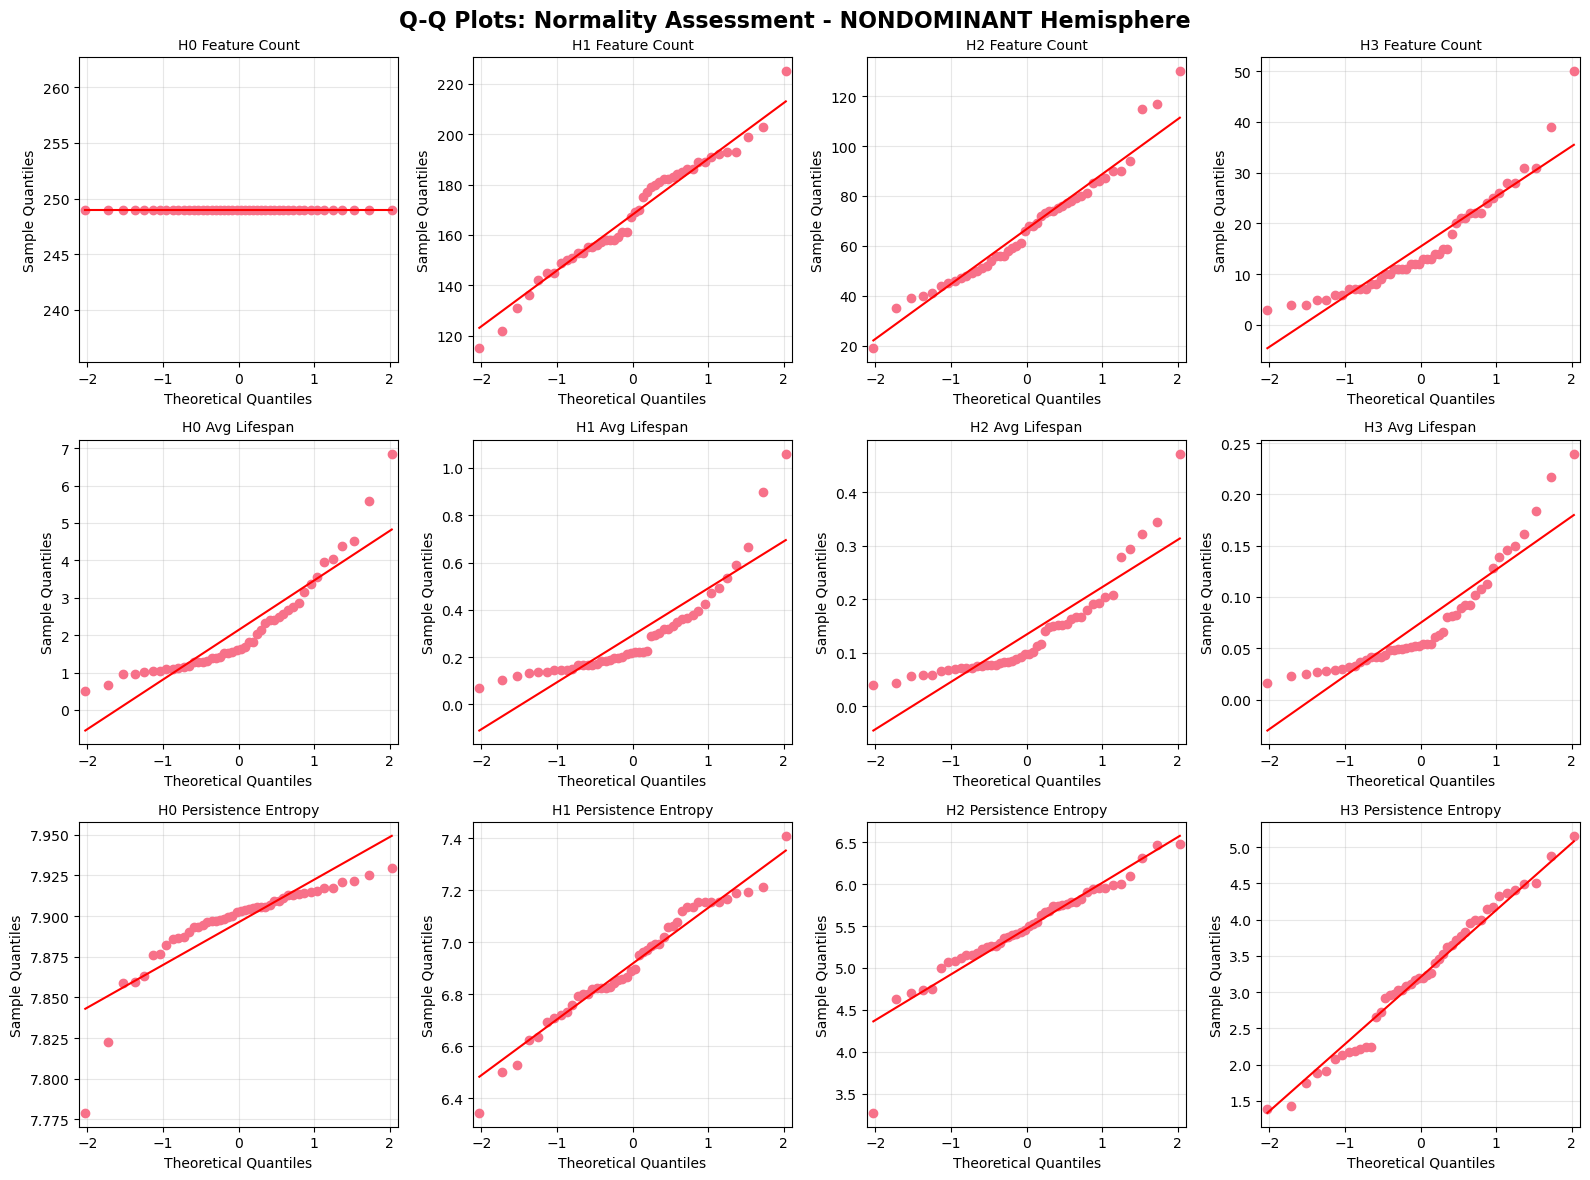

In [70]:
# Q-Q Plots for Nondominant Hemisphere
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment - NONDOMINANT Hemisphere', 
             fontsize=16, fontweight='bold')

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot for nondominant hemisphere
    sm.qqplot(df_nondominant[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
# Shapiro-Wilk Normality Tests by Hemisphere
print("Shapiro-Wilk Normality Tests by Hemisphere")
print("="*80)
print("Null hypothesis: Data is normally distributed")
print("If p-value < 0.05, reject null hypothesis (data is NOT normal)")
print("="*80)

normality_comparison = []

for feature in test_features:
    # Test dominant hemisphere
    stat_dom, p_dom = shapiro(df_dominant[feature].dropna())
    is_normal_dom = "Yes" if p_dom > 0.05 else "No"

    # Test nondominant hemisphere
    stat_nondom, p_nondom = shapiro(df_nondominant[feature].dropna())
    is_normal_nondom = "Yes" if p_nondom > 0.05 else "No"

    normality_comparison.append({
        'Feature': feature,
        'Dominant p-value': p_dom,
        'Dominant Normal?': is_normal_dom,
        'Nondominant p-value': p_nondom,
        'Nondominant Normal?': is_normal_nondom,
        'Both Normal?': 'Yes' if (is_normal_dom == 'Yes' and is_normal_nondom == 'Yes') else 'No'
    })

normality_comparison_df = pd.DataFrame(normality_comparison)

print("\n")
display(normality_comparison_df)

# Summary statistics
n_dom_normal = (normality_comparison_df['Dominant Normal?'] == 'Yes').sum()
n_nondom_normal = (normality_comparison_df['Nondominant Normal?'] == 'Yes').sum()
n_both_normal = (normality_comparison_df['Both Normal?'] == 'Yes').sum()
n_total = len(normality_comparison_df)

print(f"\n{'='*80}")
print(f"Summary (α=0.05):")
print(f"  Dominant hemisphere: {n_dom_normal}/{n_total} features normally distributed")
print(f"  Nondominant hemisphere: {n_nondom_normal}/{n_total} features normally distributed")
print(f"  Both hemispheres: {n_both_normal}/{n_total} features normally distributed in BOTH")
print(f"{'='*80}")

# Identify features with different normality between hemispheres
different_normality = normality_comparison_df[
    normality_comparison_df['Dominant Normal?'] != normality_comparison_df['Nondominant Normal?']
]

if len(different_normality) > 0:
    print("\nFeatures with DIFFERENT normality between hemispheres:")
    print("="*80)
    display(different_normality[['Feature', 'Dominant Normal?', 'Nondominant Normal?']])
    print("\nInterpretation:")
    print("  - These features show hemisphere-specific distributional differences")
    print("  - May require different statistical approaches for each hemisphere")
    print("  - Could indicate biological differences between hemispheres")
else:
    print("\nAll features show consistent normality across both hemispheres.")

Shapiro-Wilk Normality Tests by Hemisphere
Null hypothesis: Data is normally distributed
If p-value < 0.05, reject null hypothesis (data is NOT normal)




,Feature,Dominant p-value,Dominant Normal?,Nondominant p-value,Nondominant Normal?,Both Normal?
0,h0_feature_count,1.000,Yes,1.000e+00,Yes,Yes
1,h1_feature_count,0.392,Yes,5.854e-01,Yes,Yes
2,h2_feature_count,0.891,Yes,1.822e-01,Yes,Yes
3,h3_feature_count,0.003,No,4.450e-04,No,No
4,h0_avg_lifespan,0.037,No,2.372e-05,No,No
5,h1_avg_lifespan,0.004,No,9.420e-07,No,No
6,h2_avg_lifespan,0.002,No,2.803e-06,No,No
7,h3_avg_lifespan,0.012,No,1.504e-05,No,No
8,h0_persistence_entropy,0.018,No,5.467e-07,No,No
9,h1_persistence_entropy,0.134,Yes,5.089e-01,Yes,Yes



Summary (α=0.05):
  Dominant hemisphere: 4/12 features normally distributed
  Nondominant hemisphere: 5/12 features normally distributed
  Both hemispheres: 4/12 features normally distributed in BOTH

Features with DIFFERENT normality between hemispheres:


,Feature,Dominant Normal?,Nondominant Normal?
11,h3_persistence_entropy,No,Yes



Interpretation:
  - These features show hemisphere-specific distributional differences
  - May require different statistical approaches for each hemisphere
  - Could indicate biological differences between hemispheres


### Hemisphere-Specific Normality Assessment Summary

The normality tests reveal important considerations for hemisphere-specific analyses:

#### Key Findings

1. **Sample Size Effect**: With only 46 observations per hemisphere (vs 92 combined), normality assumptions may be more easily violated

2. **Hemisphere Differences**: Features that are normal in one hemisphere but not the other suggest:
   - Inherent distributional differences between hemispheres
   - Potential biological asymmetry
   - Need for hemisphere-specific statistical approaches

3. **Statistical Test Selection**:
   - **If both hemispheres normal**: Can use parametric tests (paired t-tests) for each hemisphere
   - **If one or both non-normal**: Should use non-parametric tests (Wilcoxon) for that hemisphere
   - **For hemisphere comparisons**: May need mixed-effects models or repeated-measures ANOVA
   - H0-H1-H2 feature count, H1 Persistence entropy are normally distributed for both hemispheres,
    H3 persistence entropy is normally distributed only for non-dominant hemisphere

#### Implications for Analysis

- **Symmetric normality**: Features normal in both hemispheres can be analyzed with standard parametric approaches
- **Asymmetric normality**: Features with different distributions between hemispheres are particularly interesting
  - May indicate functional specialization
  - Could reveal lateralized effects of Parkinson's disease or medication
  - Require careful choice of statistical methods

#### Recommendations

Based on normality results:
- Use **Wilcoxon signed-rank test** for non-normal features when doing hemisphere-specific paired comparisons
- Consider **permutation tests** for features with inconsistent normality across hemispheres
- Document which tests were used for which features in subsequent analyses

### Hemisphere-Specific Analysis Summary

The hemisphere-specific visualizations reveal:

#### Key Observations

**Dominant Hemisphere (Motor Control Side):**
- Controls the arm performing the hold task (contralateral motor control)
- Check if medOn/medOff effects are stronger here due to motor symptom improvement

**Nondominant Hemisphere:**
- Contralateral to the resting/non-active arm
- May show different medication response patterns

#### Lateralization Patterns to Look For

1. **Symmetric Effects**: MedOn vs MedOff differences are similar in both hemispheres
   - Suggests global medication effects on brain activity

2. **Lateralized Effects**: Differences appear only in dominant OR nondominant hemisphere
   - Suggests medication specifically affects motor-related neural activity
   - Could indicate hemisphere specialization in Parkinson's disease

3. **Differential Magnitude**: Both hemispheres show effects, but one is stronger
   - Partial lateralization of medication response

#### Visual Inspection Results

From the plots above:
- **Feature counts**: Compare H1-H3 counts between hemispheres
- **Persistence entropy**: Note any hemisphere-specific patterns in H1/H2 (oscillatory features)
- **Lifespan statistics**: Check if medication effects on temporal persistence differ by hemisphere

#### Next Steps for Hemisphere Analysis

1. Quantify lateralization with statistical tests
2. Test for interactions: hemisphere × medication state
3. Examine if dominant hemisphere shows larger effect sizes
4. Consider motor symptom lateralization in Parkinson's disease

**Note**: Formal statistical testing (mixed-effects models with hemisphere as a factor) will determine significance of these patterns.

In [66]:
# Quantitative comparison table: Hemisphere × Medication State
# Focus on key features that might show lateralization

key_comparison_features = {
    'H0 Feature Count': 'h0_feature_count',
    'H1 Feature Count': 'h1_feature_count',
    'H2 Feature Count': 'h2_feature_count',
    'H3 Feature Count': 'h3_feature_count',
    'H0 Persistence Entropy': 'h0_persistence_entropy',
    'H1 Persistence Entropy': 'h1_persistence_entropy',
    'H2 Persistence Entropy': 'h2_persistence_entropy',
    'H3 Persistence Entropy': 'h3_persistence_entropy',
    'H1 Avg Lifespan': 'h1_avg_lifespan',
    'H2 Avg Lifespan': 'h2_avg_lifespan'
}

comparison_data = []

for feature_name, feature_col in key_comparison_features.items():
    # Dominant hemisphere
    dom_medOn = df_dominant[df_dominant['med_state'] == 'medOn'][feature_col].mean()
    dom_medOff = df_dominant[df_dominant['med_state'] == 'medOff'][feature_col].mean()
    dom_diff = dom_medOn - dom_medOff

    # Nondominant hemisphere
    nondom_medOn = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature_col].mean()
    nondom_medOff = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature_col].mean()
    nondom_diff = nondom_medOn - nondom_medOff

    # Lateralization index: difference between hemisphere differences
    # Positive: dominant shows larger medOn-medOff difference
    # Negative: nondominant shows larger medOn-medOff difference
    lateralization_index = dom_diff - nondom_diff

    comparison_data.append({
        'Feature': feature_name,
        'Dom MedOn': dom_medOn,
        'Dom MedOff': dom_medOff,
        'Dom Δ': dom_diff,
        'NonDom MedOn': nondom_medOn,
        'NonDom MedOff': nondom_medOff,
        'NonDom Δ': nondom_diff,
        'Lateralization Index': lateralization_index
    })

comparison_df = pd.DataFrame(comparison_data)

print("Quantitative Hemisphere × Medication State Comparison")
print("="*70)
print("\nLegend:")
print("  Dom Δ = Dominant: MedOn - MedOff")
print("  NonDom Δ = Nondominant: MedOn - MedOff")
print("  Lateralization Index = (Dom Δ) - (NonDom Δ)")
print("    Positive: Dominant hemisphere shows larger medication effect")
print("    Negative: Nondominant hemisphere shows larger medication effect")
print("    Near zero: Symmetric effect across hemispheres")
print("="*70)
print("\n")
display(comparison_df)

# Highlight features with strongest lateralization
print("\n" + "="*70)
print("Features with Strongest Lateralization (|Index| > threshold)")
print("="*70)

# Sort by absolute lateralization index
comparison_df['Abs_Lat_Index'] = comparison_df['Lateralization Index'].abs()
lateralized_features = comparison_df.nlargest(5, 'Abs_Lat_Index')[['Feature', 'Dom Δ', 'NonDom Δ', 'Lateralization Index']]

print("\nTop 5 Most Lateralized Features:")
display(lateralized_features)

print("\nInterpretation:")
print("  - Features with large |Lateralization Index| show hemisphere-specific medication effects")
print("  - These may be the most interesting for understanding lateralized Parkinson's pathology")

Quantitative Hemisphere × Medication State Comparison

Legend:
  Dom Δ = Dominant: MedOn - MedOff
  NonDom Δ = Nondominant: MedOn - MedOff
  Lateralization Index = (Dom Δ) - (NonDom Δ)
    Positive: Dominant hemisphere shows larger medication effect
    Negative: Nondominant hemisphere shows larger medication effect
    Near zero: Symmetric effect across hemispheres




,Feature,Dom MedOn,Dom MedOff,Dom Δ,NonDom MedOn,NonDom MedOff,NonDom Δ,Lateralization Index
0,H0 Feature Count,249.000,249.000,0.000e+00,249.000,249.000,0.000,0.000
1,H1 Feature Count,164.727,166.625,-1.898e+00,164.682,171.125,-6.443,4.545
2,H2 Feature Count,59.909,61.250,-1.341e+00,63.500,69.708,-6.208,4.867
3,H3 Feature Count,11.409,14.333,-2.924e+00,13.909,16.875,-2.966,0.042
4,H0 Persistence Entropy,7.893,7.887,5.940e-03,7.892,7.900,-0.007,0.013
5,H1 Persistence Entropy,6.901,6.902,-8.286e-04,6.872,6.958,-0.086,0.086
6,H2 Persistence Entropy,5.378,5.362,1.582e-02,5.358,5.573,-0.215,0.231
7,H3 Persistence Entropy,2.840,2.962,-1.227e-01,2.992,3.402,-0.410,0.287
8,H1 Avg Lifespan,0.294,0.280,1.404e-02,0.318,0.269,0.049,-0.035
9,H2 Avg Lifespan,0.134,0.127,6.504e-03,0.144,0.124,0.020,-0.014



Features with Strongest Lateralization (|Index| > threshold)

Top 5 Most Lateralized Features:


,Feature,Dom Δ,NonDom Δ,Lateralization Index
2,H2 Feature Count,-1.341e+00,-6.208,4.867
1,H1 Feature Count,-1.898e+00,-6.443,4.545
7,H3 Persistence Entropy,-1.227e-01,-0.410,0.287
6,H2 Persistence Entropy,1.582e-02,-0.215,0.231
5,H1 Persistence Entropy,-8.286e-04,-0.086,0.086



Interpretation:
  - Features with large |Lateralization Index| show hemisphere-specific medication effects
  - These may be the most interesting for understanding lateralized Parkinson's pathology
